In [2]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

/home/kramosmu/anaconda/lib/python2.7/site-packages/mpl_toolkits/__init__.py:2: UserWarning: Module MITgcmutils was already imported from MITgcmutils/__init__.pyc, but /home/kramosmu/anaconda/lib/python2.7/site-packages/MITgcmutils-0.1.0-py2.7.egg is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


In [12]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import TransportTools_MITgcm as trt

In [13]:
def calc_sigmaHor(RhoRef,T,S, At = 2.0E-4, Bs = 7.4E-4):
    '''Calculate sigma as sigma = sigma0 + (RhoRef[Bs(S-S0) - At(T-T0)]) with sigma0 = 0, T0 = 0 and S0 = 0.
       RhoRef: Reference salinity at model layer nz, matching z of T and S.
       T : 2D Temp field (nx,ny) at z
       S : 2D Salt field (nx,ny) at z
       At: Thermal expansion coefficient (units K^-1)
       Bs: Haline expansion coefficient (units ppt^-1)
       
       returns sigma : 2D density anomaly 
    '''
    
    sigma = RhoRef*(Bs*S - At*T)
    return sigma
    

In [14]:
def calc_sigmaVer(RhoRef,T,S, At = 2.0E-4, Bs = 7.4E-4):
    '''Calculate sigma as sigma = sigma0 + (RhoRef[Bs(S-S0) - At(T-T0)]) with sigma0 = 0, T0 = 0 and S0 = 0.
       RhoRef: Reference density profile at nx,ny.
       T : 1D Temp field at nx,ny 
       S : 1D Salt field at nx,ny
       At: Thermal expansion coefficient (units K^-1)
       Bs: Haline expansion coefficient (units ppt^-1)
       
       returns sigma : 1D density anomaly profile
    '''
    
    sigma = RhoRef*(Bs*S - At*T)
    return sigma

In [15]:
sns.set()
sns.set_style('darkgrid')
sns.set_context('notebook')

In [365]:
filename1a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/state.0000000000.glob.nc'
StateOuta = Dataset(filename1a)


filename2a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/grid.glob.nc'
GridOuta = Dataset(filename2a)

#for dimobj in GridOuta.variables.values():
#    print dimobj

filename3a='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/ptracers.0000000000.glob.nc'
PtracersOuta = Dataset(filename3a)


filename1b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/stateGlob.nc'
StateOutb = Dataset(filename1b)


filename2b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/gridGlob.nc'
GridOutb = Dataset(filename2b)


filename3b='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/ptracersGlob.nc'
PtracersOutb = Dataset(filename3b)

RhoRefa = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/RhoRef'))
RhoRefb = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/RhoRef'))

/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run13/RhoRef.meta
/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_3DdiffKz/run01/RhoRef.meta


In [304]:
# General input

nx = 360
ny = 360
nz = 90

nt = 19 # t dimension size 

Bs = 7.4E-4 # ppt^-1
At = 2.0E-4 # K^-1

z = StateOuta.variables['Z']
#print(z[10])
Time = StateOuta.variables['T']
#print(Time[:])
xc = rout.getField(filename2a, 'XC') # x coords tracer cells
yc = rout.getField(filename2a, 'YC') # y coords tracer cells

drF= GridOuta.variables['drF'] # vertical distance between faces
bathy = rout.getField(filename2a, 'Depth')

rA = rout.getField(filename2a, 'rA') # area of cells (x-y)
hFacC = rout.getField(filename2a, 'HFacC')
MaskC = rout.getMask(filename2a,'HFacC') # same for both runs

In [18]:
Tempa = rout.getField(filename1a,'Temp') # T and S of CNT run (run13)
Salta = rout.getField(filename1a,'S')

In [19]:
Tempb = rout.getField(filename1b,'Temp') # T and S of Kzdiff3D run (run01)
Saltb = rout.getField(filename1b,'S')

In [1]:
Bs = 7.4E-4 # Haline and thermal expansion coefficients of linear EoS
At = 2.0E-4

zlev=35 

In [23]:
Tr1CNT = rout.getField(filename3a,'Tr1') # Tracer 1 CNT run , Kz = E-5
Tr2CNT = rout.getField(filename3a,'Tr2') # Tracer 2 CNT run , Kz = E-3
Tr13D = rout.getField(filename3b,'Tr1') # Tracer 1 KzDiff3D run , Kz_cny = E-3, Kz_out = E-5


#Comparison of profiles in different locations within and around the canyon

52100.0


/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kramosmu/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


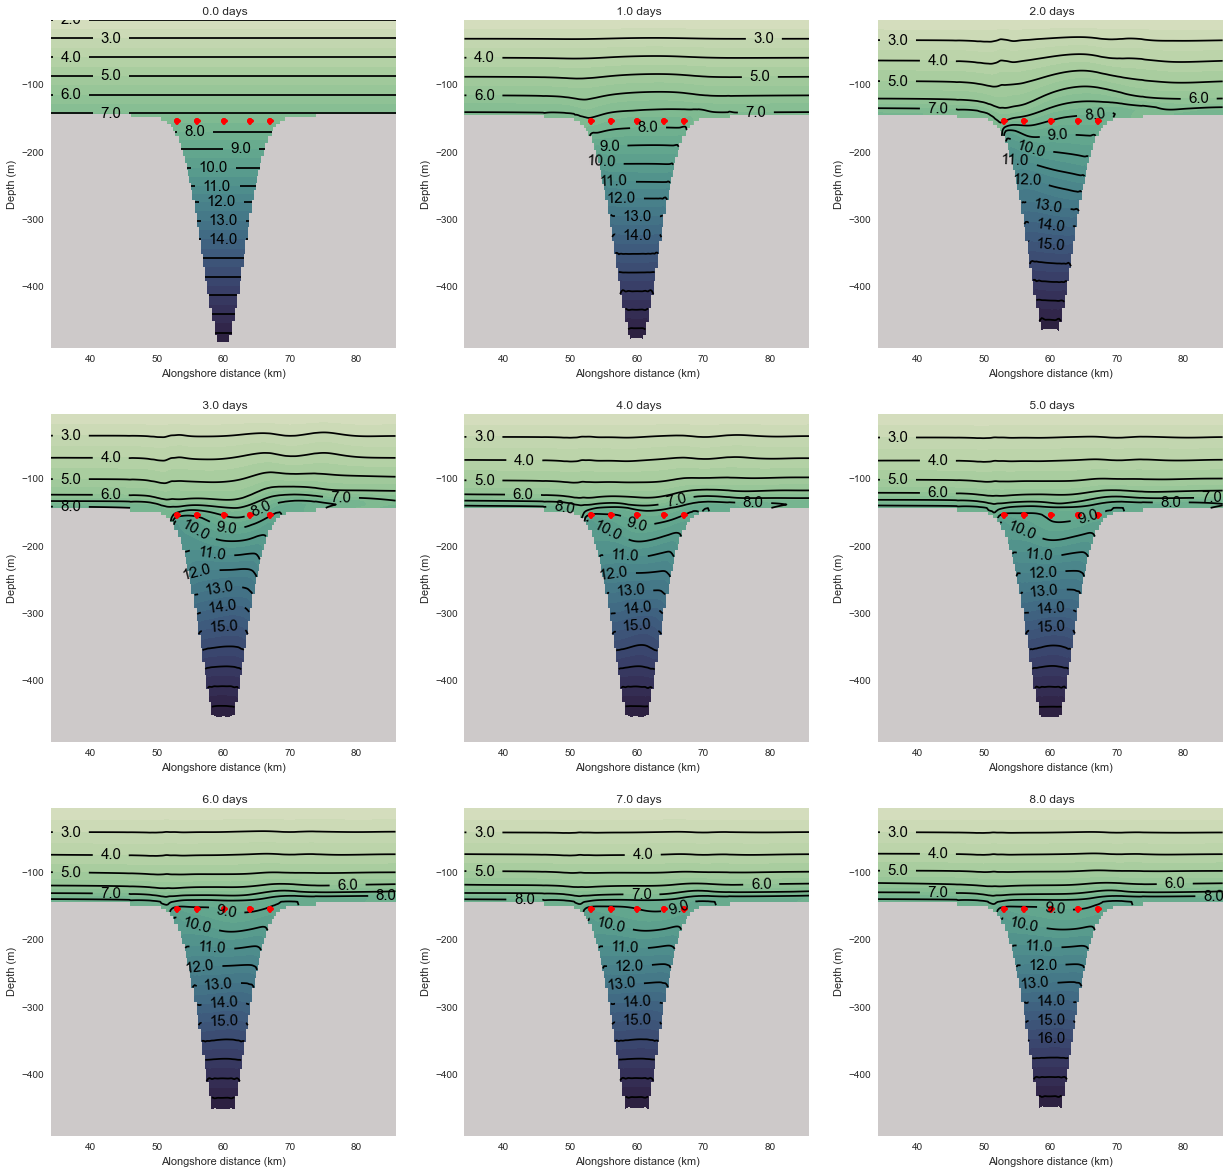

In [31]:
sns.set_style('dark')
plt.rcParams.update({'font.size':15})

kk=1

fig45=plt.figure(figsize=(21,20))

pal = sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)

for tt in range(0,18,2) :
        
        ### Upstream speed 
        
        plt.subplot(3,3,kk)
        ax = plt.gca()
        ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
        Tr13Dmask=np.ma.array(Tr13D[tt,:,:,:],mask=MaskC[:,:,:])
    
        #Trmask=np.ma.array(temp[tt,:,:,:],mask=MASKhFacC[:,:,:])
        #fig1=plt.pcolor(xc[190,50:-50],z[:-30],Trmask[:-30,190,50:-50],cmap='rainbow')
        levels=np.arange(2,20,0.5)
        CS=plt.contourf(xc[200,50:-50],z[:-35],Tr13Dmask[:-35,200,50:-50],levels,cmap=pal)
        #cb = plt.colorbar()
        #plt.clim([9, 14])
        
        CS2 = plt.contour(CS, levels=CS.levels[::2],
                        colors = 'k',
                        hold='on')
        plt.clabel(CS2, fmt = '%2.1f', colors = 'k')
        
        plt.plot(xc[200,200],z[30],'ro')
        plt.plot(xc[200,160],z[30],'ro')
        plt.plot(xc[200,180],z[30],'ro')
        plt.plot(xc[200,215],z[30],'ro')
        plt.plot(xc[200,145],z[30],'ro')
        
        
        plt.ylabel('Depth (m)')
        plt.xlabel('Alongshore distance (km)')
        cb.set_label('[C]', position=(1, 0),rotation=0)
        labels = [40, 50, 60, 70, 80]
        plt.xticks([40000,50000,60000,70000,80000], labels)
        plt.title(" %1.1f days " % (tt/2.))
       
            
        kk=kk+1
print(yc[200,0]) 


In [99]:
def ProfilesAcross(IniProfArray, maskC,Tr1,Tr2,z, label1, label2,xlabel):
    '''Plot profiles of two arrays at stations across the canyon (indices [:37,200,145],[:37,200,180],[:37,200,215] )'''
    # Profiles
    fig444=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    IniProf=np.ma.array(IniProfArray[0,:37,200,180],mask=maskC[:37,200,180])
    
    with sns.diverging_palette(154, 16, n=6, center="light") :
    
        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            Tr1mask=np.ma.array(Tr1[tt,:,:,:],mask=maskC[:,:,:])
            Tr2mask=np.ma.array(Tr2[tt,:,:,:],mask=maskC[:,:,:])

            plt.plot(Tr1mask[:37,200,145],z[:37],'o-',label=('%s upstr' %label1))
            plt.plot(Tr2mask[:37,200,145],z[:37],'o-',label=('%s upstr' %label2))

            #plt.plot(Tr1mask[:37,200,160],z[:37],'o-',label=('%s upmid' %label1))
            #plt.plot(Tr2mask[:37,200,160],z[:37],'o-',label=('%s upmid' %label2))

            plt.plot(Tr1mask[:37,200,180],z[:37],'o-',label=('%s mid' %label1))
            plt.plot(Tr2mask[:37,200,180],z[:37],'o-',label=('%s mid' %label2))

            #plt.plot(Tr1mask[:37,200,200],z[:37],'o-',label=('%s dwmid' %label1))
            #plt.plot(Tr2mask[:37,200,200],z[:37],'o-',label=('%s dwmid' %label2))

            plt.plot(Tr1mask[:37,200,215],z[:37],'o-',label=('%s dwstr' %label1))
            plt.plot(Tr2mask[:37,200,215],z[:37],'o-',label=('%s dwstr' %label2))

            plt.plot(IniProf,z[:37],'-w')

            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
    


In [98]:
def ProfilesAcrossAnom(IniProfArray, maskC,Tr1,Tr2,z, label1, label2,xlabel):
    '''Plot profiles of two arrays at stations across the canyon (indices [:37,200,145],[:37,200,180],[:37,200,215] )'''
    # Profiles
    fig444=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    IniProf=np.ma.array(IniProfArray[0,:37,200,180],mask=maskC[:37,200,180])
    
    with sns.diverging_palette(154, 16, n=6, center="light") :
    
        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            Tr1mask=np.ma.array(Tr1[tt,:,:,:],mask=maskC[:,:,:])
            Tr2mask=np.ma.array(Tr2[tt,:,:,:],mask=maskC[:,:,:])

            plt.plot(Tr1mask[:37,200,145]-IniProf,z[:37],'o-',label=('%s upstr' %label1))
            plt.plot(Tr2mask[:37,200,145]-IniProf,z[:37],'o-',label=('%s upstr' %label2))

            #plt.plot(Tr1mask[:37,200,160]-IniProf,z[:37],'o-',label=('%s upmid' %label1))
            #plt.plot(Tr2mask[:37,200,160]-IniProf,z[:37],'o-',label=('%s upmid' %label2))

            plt.plot(Tr1mask[:37,200,180]-IniProf,z[:37],'o-',label=('%s mid' %label1))
            plt.plot(Tr2mask[:37,200,180]-IniProf,z[:37],'o-',label=('%s mid' %label2))

            #plt.plot(Tr1mask[:37,200,200],z[:37],'o-',label=('%s dwmid' %label1))
            #plt.plot(Tr2mask[:37,200,200],z[:37],'o-',label=('%s dwmid' %label2))

            plt.plot(Tr1mask[:37,200,215]-IniProf,z[:37],'o-',label=('%s dwstr' %label1))
            plt.plot(Tr2mask[:37,200,215]-IniProf,z[:37],'o-',label=('%s dwstr' %label2))

            
            plt.plot(IniProf-IniProf,z[:37],'-k')
            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
    


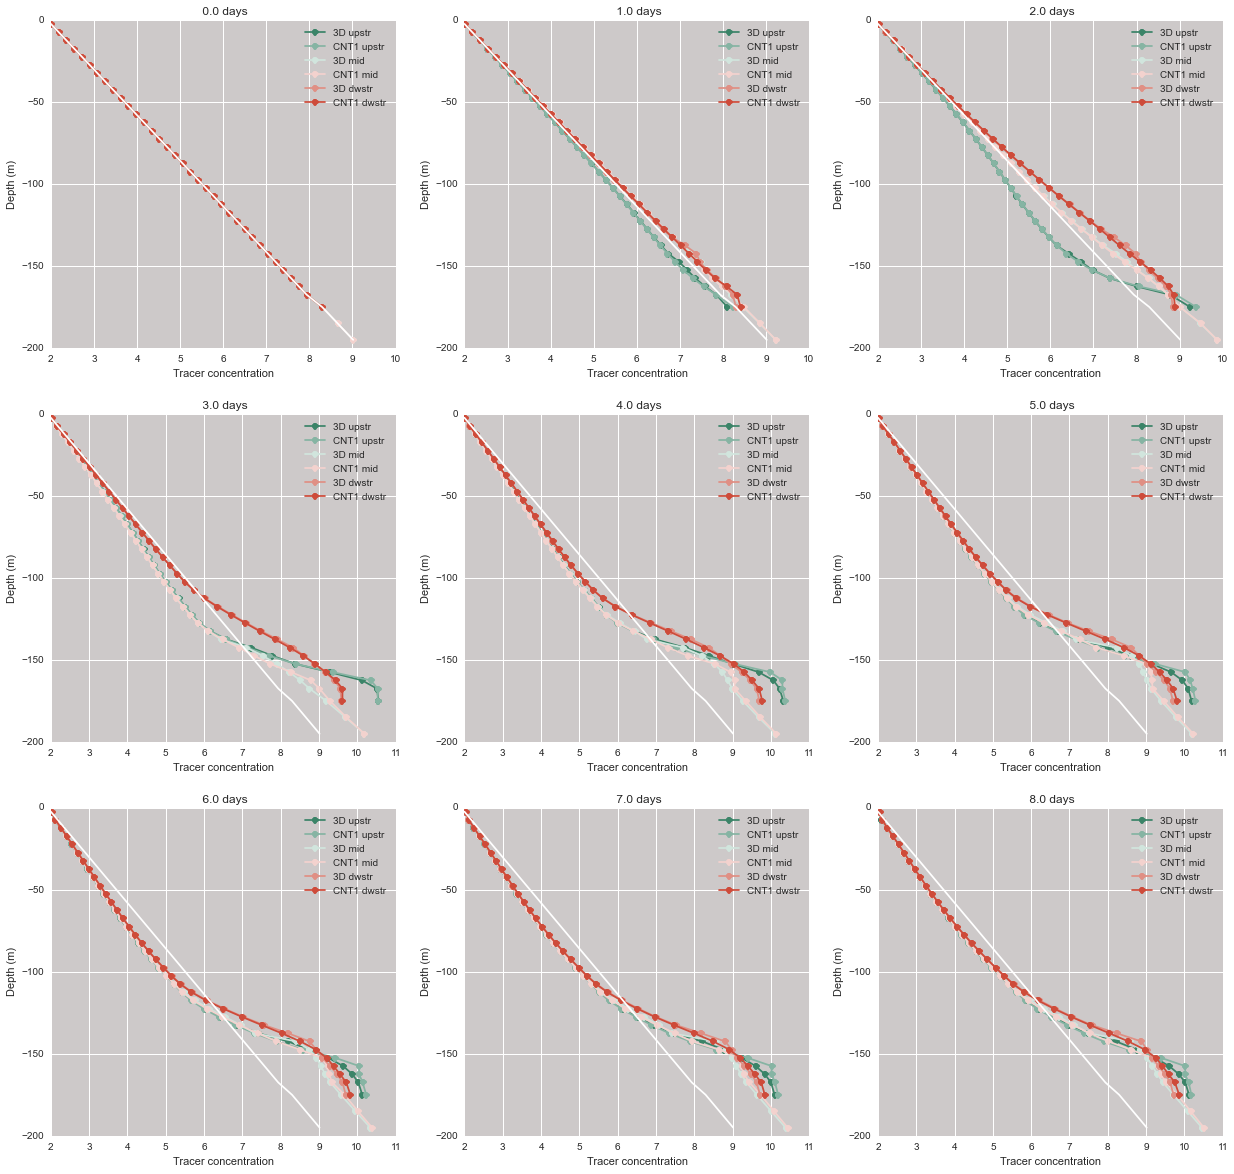

In [100]:
ProfilesAcross(Tr13D, MaskC,Tr13D,Tr1CNT,z, '3D', 'CNT1', 'Tracer concentration')

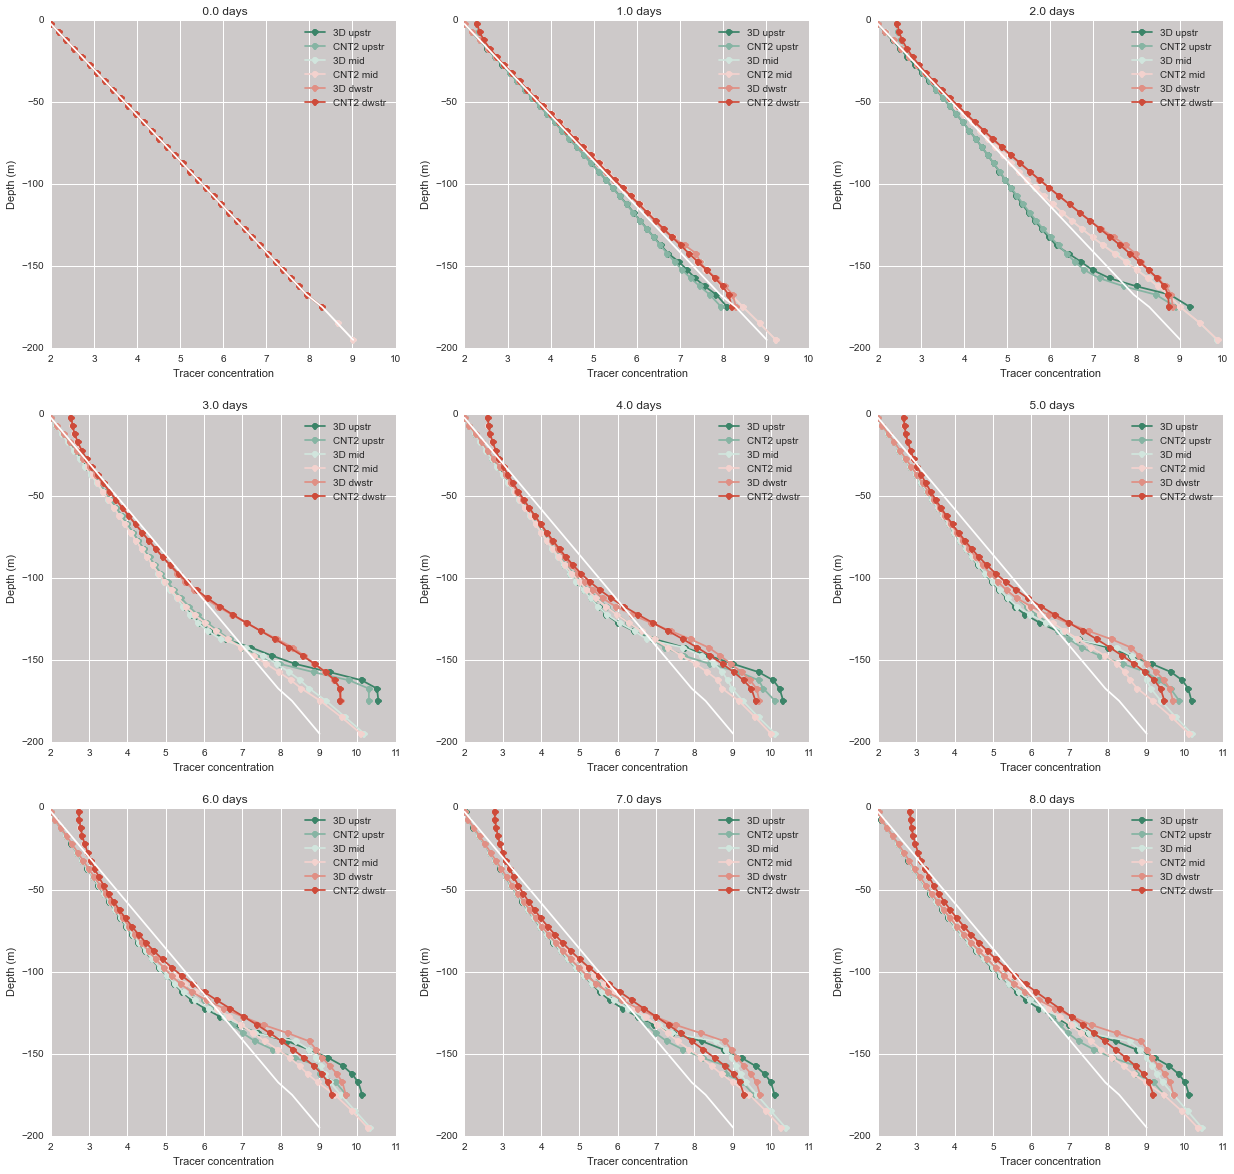

In [101]:
ProfilesAcross(Tr13D, MaskC,Tr13D,Tr2CNT,z, '3D', 'CNT2', 'Tracer concentration')

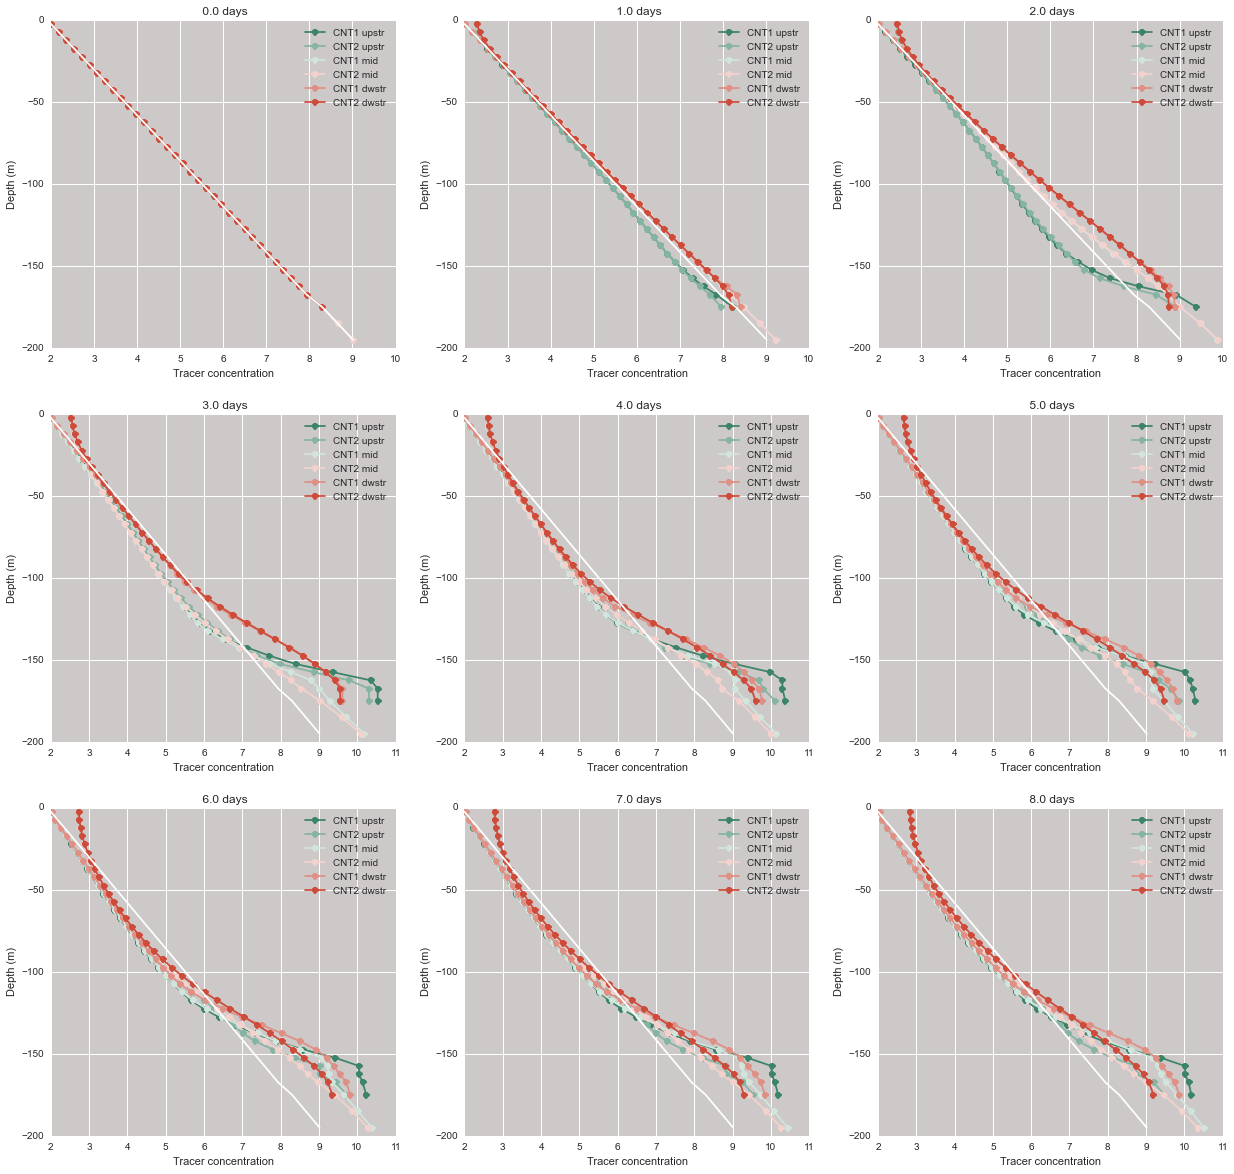

In [102]:
ProfilesAcross(Tr1CNT, MaskC,Tr1CNT,Tr2CNT,z, 'CNT1', 'CNT2', 'Tracer concentration')

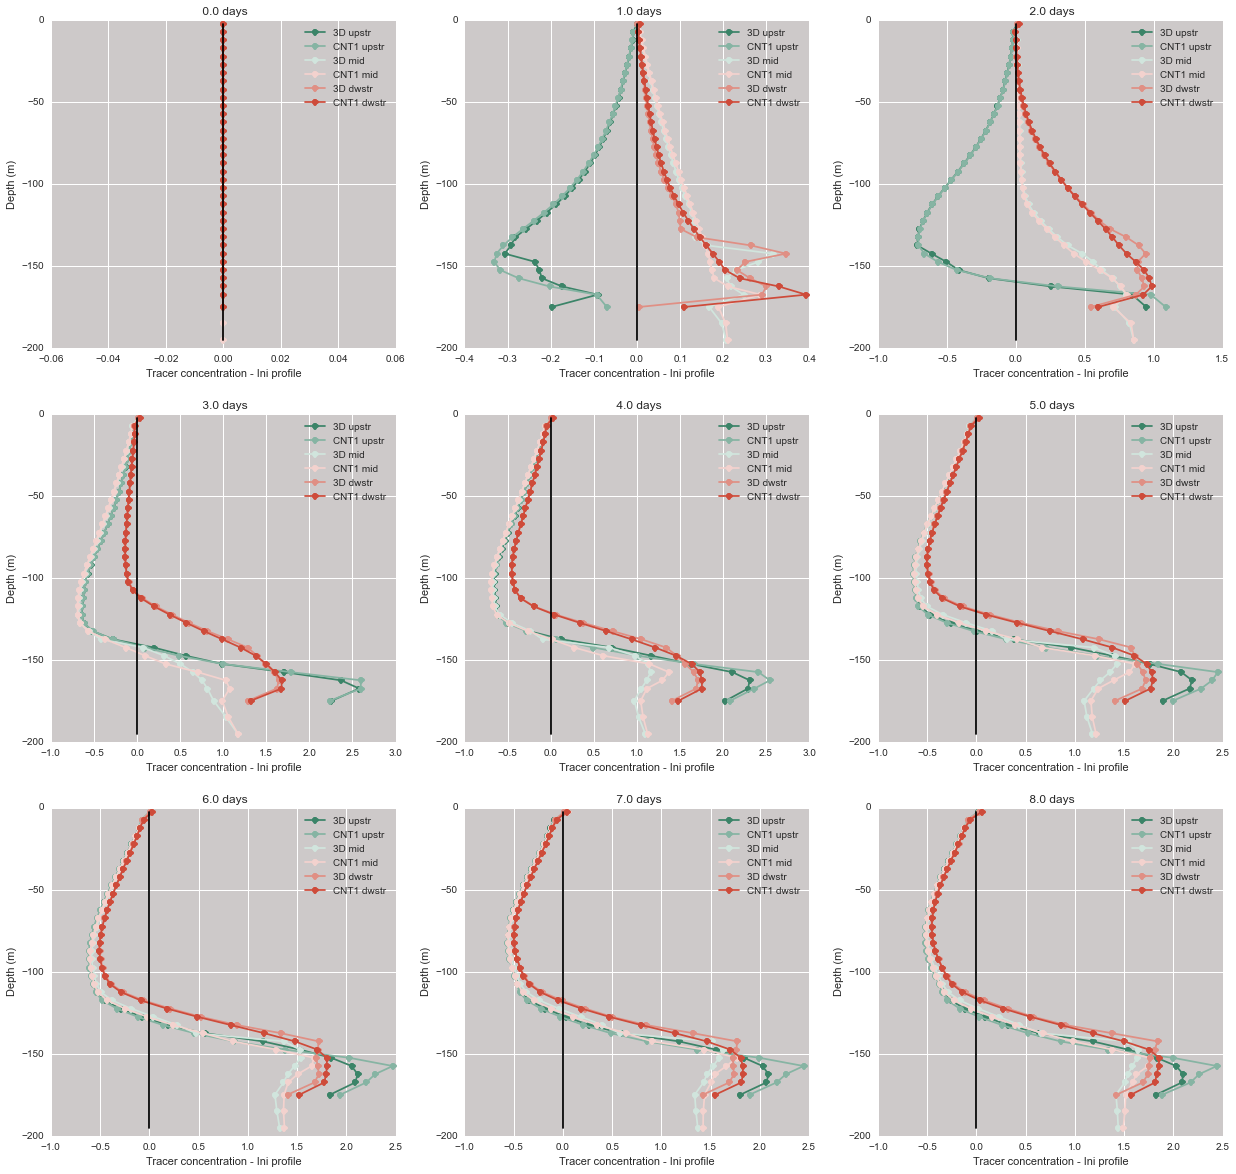

In [104]:
ProfilesAcrossAnom(Tr13D, MaskC,Tr13D,Tr1CNT,z, '3D', 'CNT1','Tracer concentration - Ini profile')

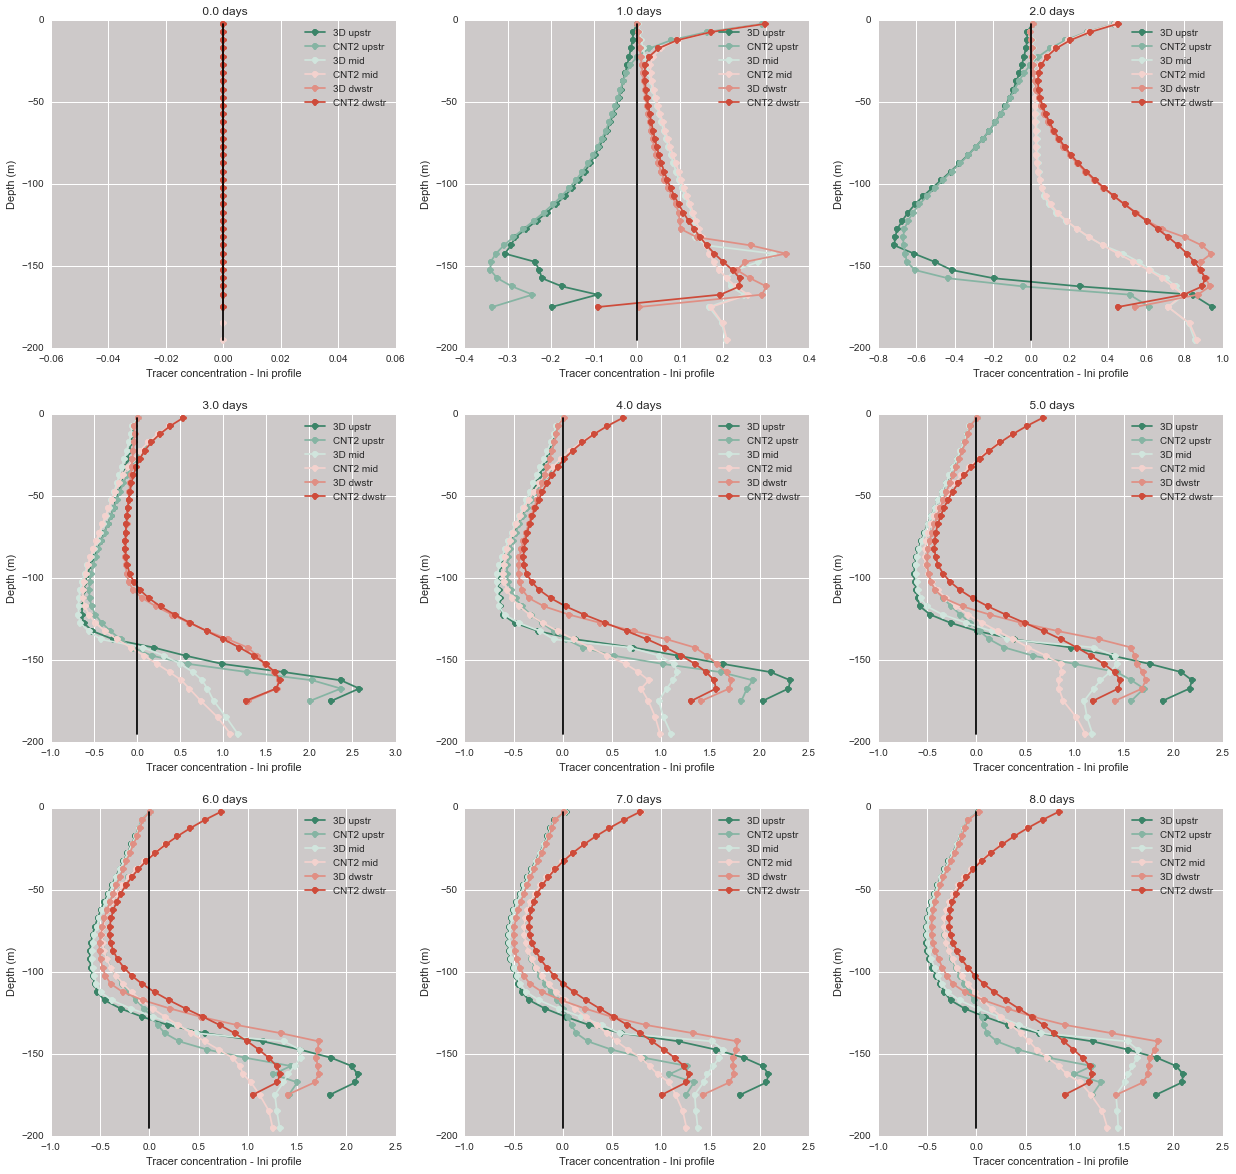

In [105]:
ProfilesAcrossAnom(Tr13D, MaskC,Tr13D,Tr2CNT,z, '3D', 'CNT2', 'Tracer concentration - Ini profile')

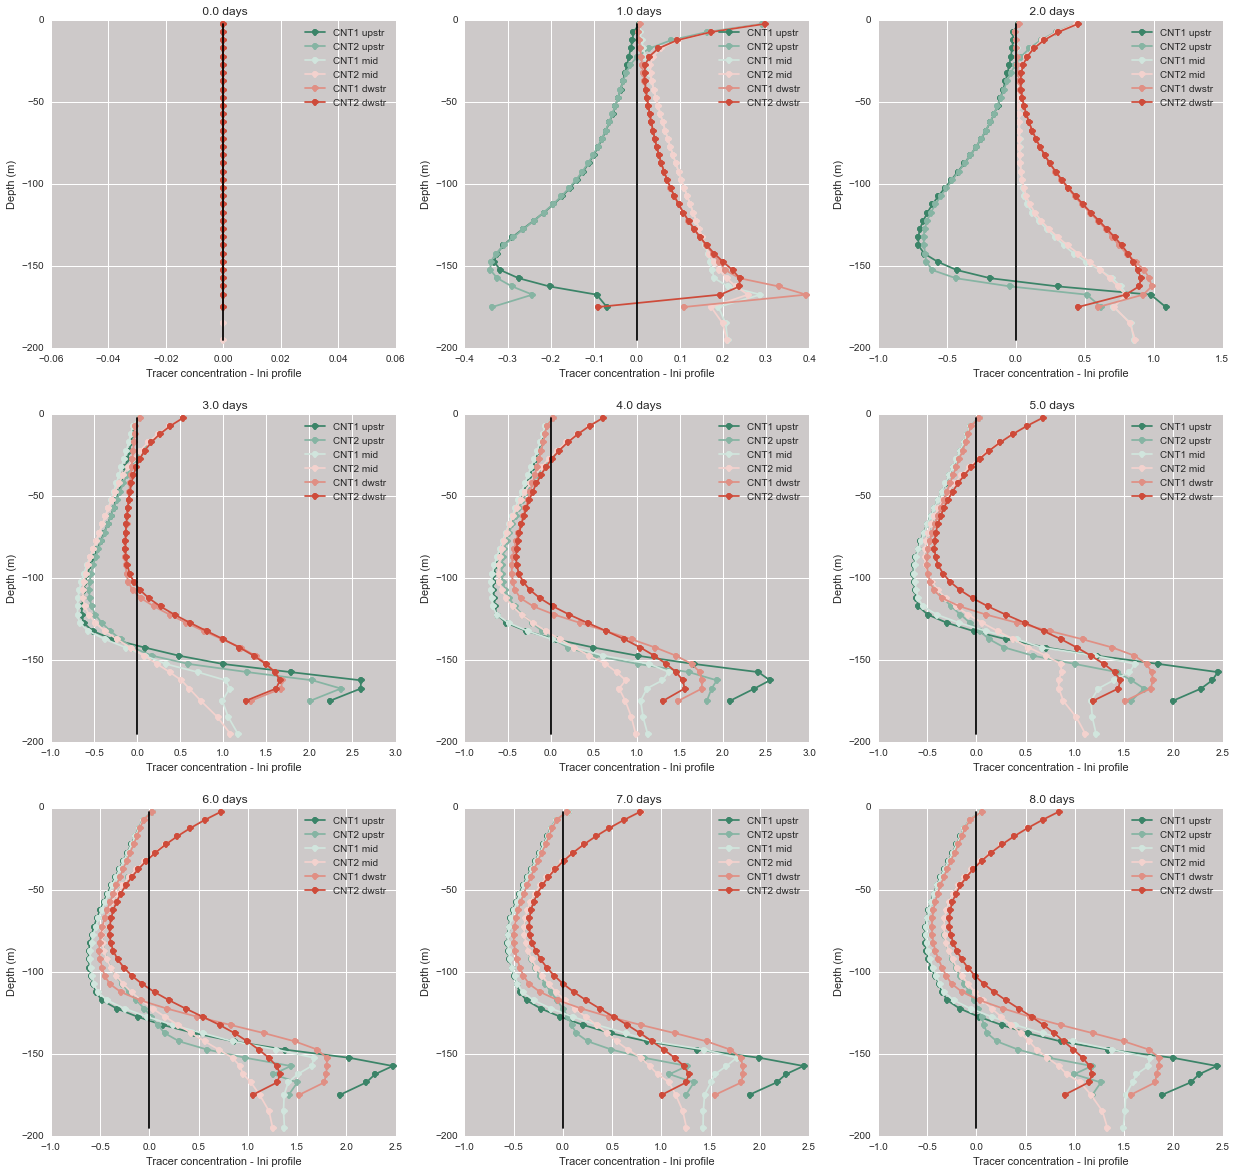

In [106]:
ProfilesAcrossAnom(Tr1CNT, MaskC,Tr1CNT,Tr2CNT, z,'CNT1', 'CNT2', 'Tracer concentration - Ini profile')

In [107]:
def ProfilesAcrossRho(Temp1,Temp2,Salt1,Salt2,maskC, RhoRef1, RhoRef2,z,label1,label2,xlabel):
        # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1
    TempMask1=np.ma.array(Temp1[0,:37,200,180],mask=MaskC[:37,200,180])
    SaltMask1=np.ma.array(Salt1[0,:37,200,180],mask=MaskC[:37,200,180])
    sigmaIni = RhoRef1[:37]*(Bs*SaltMask1 - At*TempMask1 )

    with sns.diverging_palette(220, 20, n=6, center="light") :

        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TempMask1=np.ma.array(Temp1[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMask1=np.ma.array(Salt1[tt,:,:,:],mask=MaskC[:,:,:])
            
            TempMask2=np.ma.array(Temp2[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMask2=np.ma.array(Salt2[tt,:,:,:],mask=MaskC[:,:,:])
            
            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,200,145] - At*TempMask2[:,200,145] )
            plt.plot(sigma2[:37]-sigmaIni,z[:37],'o-',label=('%s upstr' %label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,200,145] - At*TempMask1[:,200,145] )
            plt.plot(sigma1[:37]-sigmaIni,z[:37],'o-',label=('%s upstr' %label1))

            #sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,200,160] - At*TempMaskb[:,200,160] )
            #plt.plot(sigmab[:37]-RhoRefb[:37],z[:37],'o-',label='CNT upmid')
            #sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,200,160] - At*TempMaska[:,200,160] )
            #plt.plot(sigmaa[:37]-RhoRefa[:37],z[:37],'o-',label='3D upmid')

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,200,180] - At*TempMask2[:,200,180] )
            plt.plot(sigma2[:37]-sigmaIni,z[:37],'o-',label=('%s mid' %label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,200,180] - At*TempMask1[:,200,180] )
            plt.plot(sigma1[:37]-sigmaIni,z[:37],'o-',label=('%s mid' %label1))

            #sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,200,200] - At*TempMaskb[:,200,200] )
            #plt.plot(sigmab[:37]-RhoRefb[:37],z[:37],'o-',label='CNT dwmid')
            #sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,200,200] - At*TempMaska[:,200,200] )
            #plt.plot(sigmaa[:37]-RhoRefa[:37],z[:37],'o-',label='3D dwmid')

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,200,215] - At*TempMask2[:,200,215] )
            plt.plot(sigma2[:37]-sigmaIni,z[:37],'o-',label=('%s dwstr' %label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,200,215] - At*TempMask1[:,200,215] )
            plt.plot(sigma1[:37]-sigmaIni,z[:37],'o-',label=('%s dwstr' %label1))

            plt.plot(sigmaIni-sigmaIni,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)
            cb.set_label('$^oC$', position=(1, 0),rotation=0)
            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
   

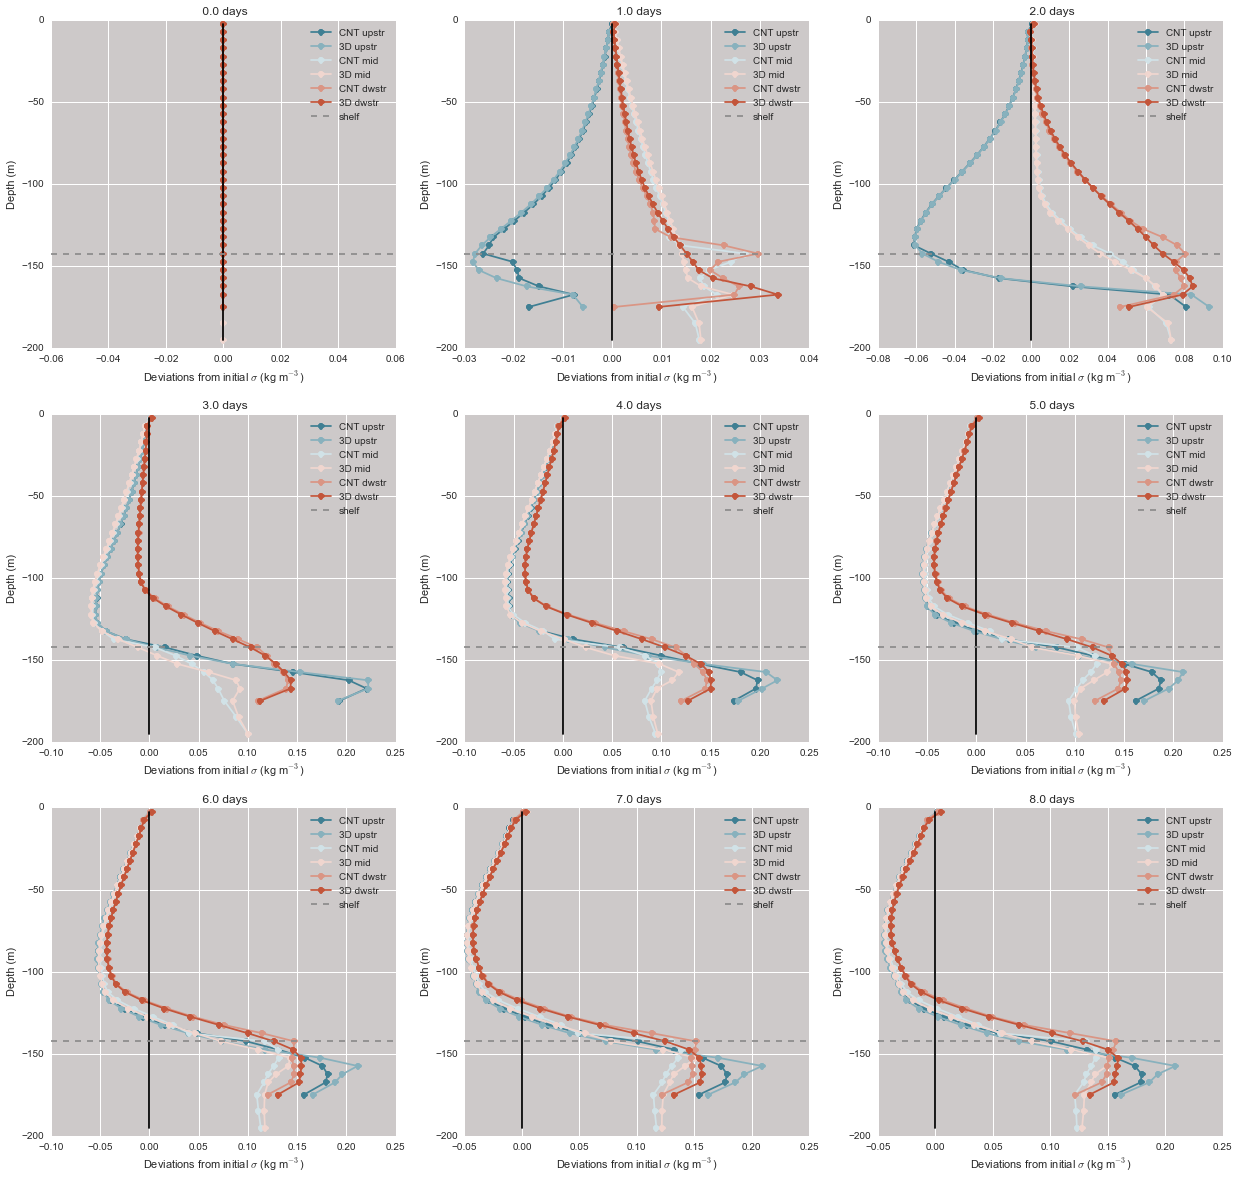

In [108]:
ProfilesAcrossRho(Tempa,Tempb,Salta,Saltb,MaskC, RhoRefa, RhoRefb,z,'3D','CNT','Deviations from initial $\sigma$ (kg m$^{-3}$)')

In [109]:
def ProfilesAlongRho(Temp1,Temp2,Salt1,Salt2,maskC, RhoRef1, RhoRef2,z,label1,label2,xlabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    TempMask1=np.ma.array(Temp1[0,:37,200,180],mask=MaskC[:37,200,180])
    SaltMask1=np.ma.array(Salt1[0,:37,200,180],mask=MaskC[:37,200,180])
    sigmaIni = RhoRef1[:37]*(Bs*SaltMask1 - At*TempMask1 )


    with sns.diverging_palette(220, 20, n=8, center="light") :

        for tt in range(2,19,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TempMask1=np.ma.array(Temp1[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMask1=np.ma.array(Salt1[tt,:,:,:],mask=MaskC[:,:,:])
            TempMask2=np.ma.array(Temp2[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMask2=np.ma.array(Salt2[tt,:,:,:],mask=MaskC[:,:,:])

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,220,180] - At*TempMask2[:,220,180] )
            plt.plot(sigma2[:37]-sigmaIni,z[:37],'o-',label=('%s head' %label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,220,180] - At*TempMask1[:,220,185] )
            plt.plot(sigma1[:37]-sigmaIni,z[:37],'o-',label=('%s head' %label1))

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,210,180] - At*TempMask2[:,210,180] )
            plt.plot(sigma2[:37]-sigmaIni[:37],z[:37],'o-',label=('%s midhead'%label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,210,180] - At*TempMask1[:,210,180] )
            plt.plot(sigma1[:37]-sigmaIni[:37],z[:37],'o-',label=('%s midhead'%label1))

            #sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,200,180] - At*TempMaskb[:,200,180] )
            #plt.plot(sigmab[:37]-sigmaIni,z[:37],'o-',label='CNT mid')
            #sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,200,180] - At*TempMaska[:,200,180] )
            #plt.plot(sigmaa[:37]-sigmaIni,z[:37],'o-',label='3D mid')

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,180,180] - At*TempMask2[:,180,180] )
            plt.plot(sigma2[:37]-sigmaIni[:37],z[:37],'o-',label=('%s midmouth'%label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,180,180] - At*TempMask1[:,180,180] )
            plt.plot(sigma1[:37]-sigmaIni[:37],z[:37],'o-',label=('%s midmouth'%label1))

            sigma2 = RhoRef2[:]*(Bs*SaltMask2[:,160,180] - At*TempMask2[:,160,180] )
            plt.plot(sigma2[:37]-sigmaIni,z[:37],'o-',label=('%s mouth' %label2))
            sigma1 = RhoRef1[:]*(Bs*SaltMask1[:,160,180] - At*TempMask1[:,160,180] )
            plt.plot(sigma1[:37]-sigmaIni,z[:37],'o-',label=('%s mouth' %label1))

            plt.plot(sigmaIni-sigmaIni,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)
            cb.set_label('$^oC$', position=(1, 0),rotation=0)
            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
    



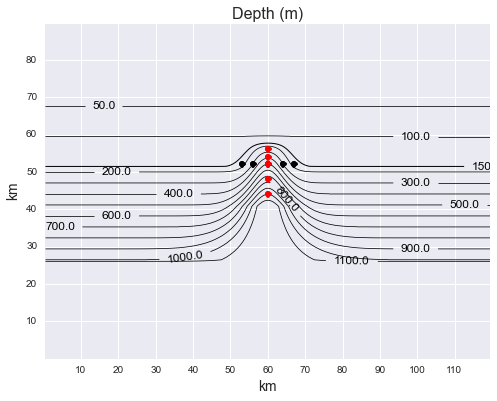

In [38]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(8,6))

### across canyon profiles ###
plt.plot(xc[200,200],yc[200,200],'ko')
plt.plot(xc[200,160],yc[200,160],'ko')
plt.plot(xc[200,180],yc[200,180],'ko')
plt.plot(xc[200,215],yc[200,215],'ko')
plt.plot(xc[200,145],yc[200,145],'ko')
        
### along canyon profiles ###
plt.plot(xc[200,180],yc[200,180],'ro')
plt.plot(xc[210,180],yc[210,180],'ro')
plt.plot(xc[220,180],yc[220,180],'ro')
plt.plot(xc[180,180],yc[180,180],'ro')
plt.plot(xc[160,180],yc[160,180],'ro')

lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=12)



plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)




#plt.savefig('AcrossShoreLines.png', bbox_inches='tight')
#plt.savefig('AcrossShoreLines.pdf', bbox_inches='tight')


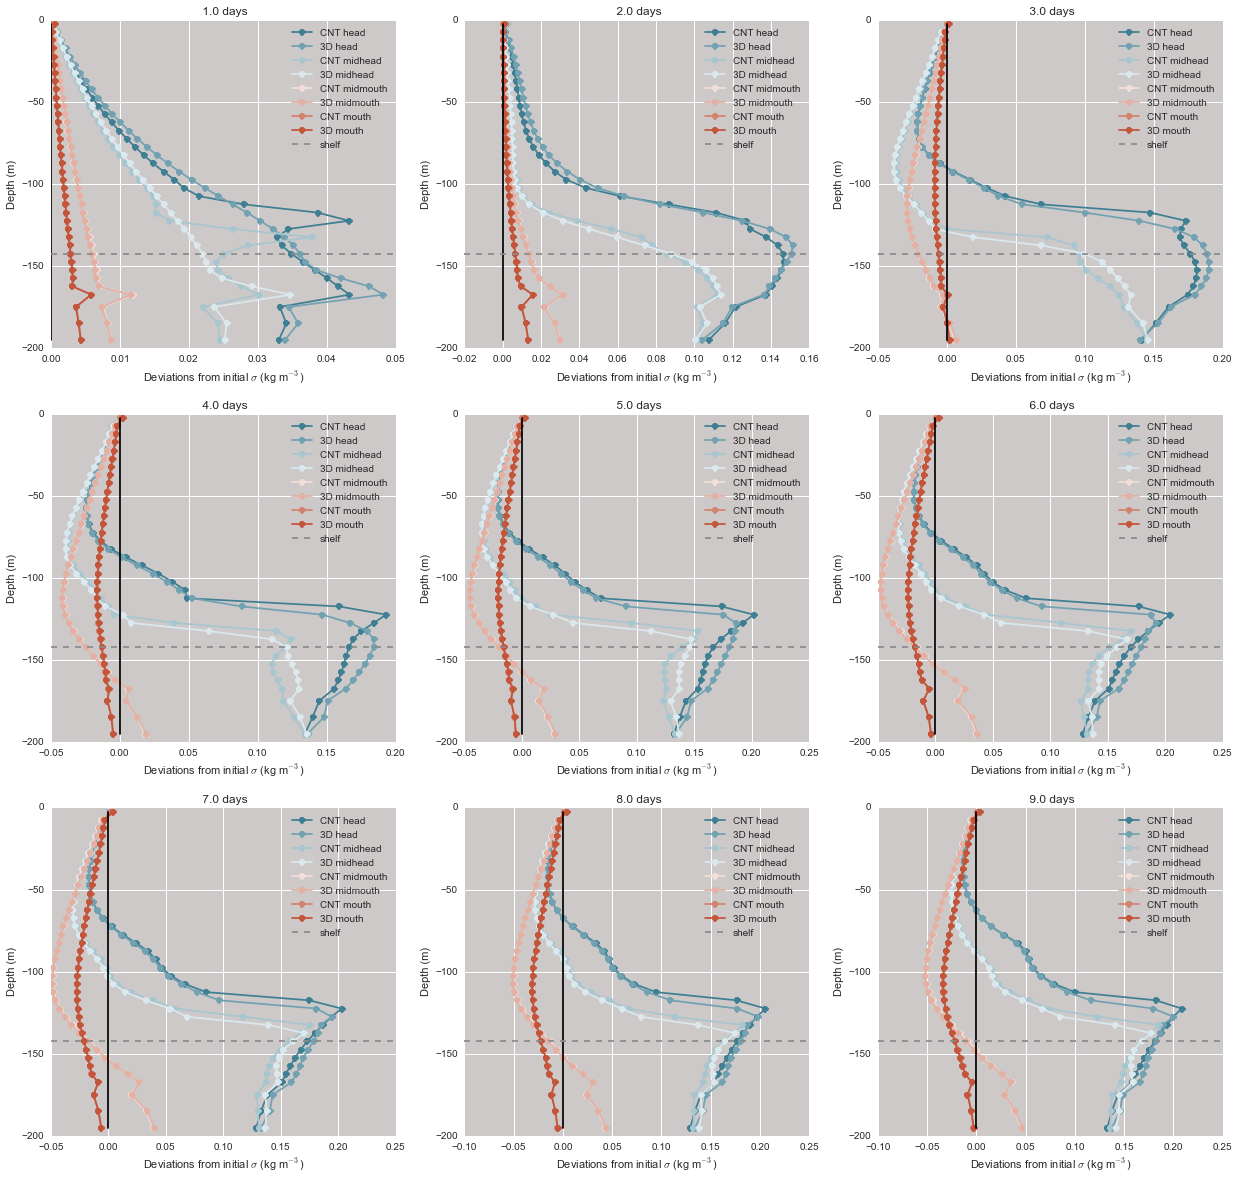

In [110]:
ProfilesAlongRho(Tempa,Tempb,Salta,Saltb,MaskC, RhoRefa, RhoRefb,z,'3D','CNT','Deviations from initial $\sigma$ (kg m$^{-3}$)')

In [111]:
def ProfilesAlong(IniProfArray,maskC,Tr1,Tr2,z,label1,label2,xlabel):
        # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    IniProf=np.ma.array(IniProfArray[0,:37,200,180],mask=maskC[:37,200,180])

    with sns.diverging_palette(154, 16, n=8, center="light") :

        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            Tr1mask=np.ma.array(Tr1[tt,:,:,:],mask=maskC[:,:,:])
            Tr2mask=np.ma.array(Tr2[tt,:,:,:],mask=maskC[:,:,:])

            plt.plot(Tr1mask[:37,220,180],z[:37],'o-',label=('%s head' %label1))
            plt.plot(Tr2mask[:37,220,180],z[:37],'o-',label=('%s head' %label2))

            plt.plot(Tr1mask[:37,210,180],z[:37],'o-',label=('%s midhead' %label1))
            plt.plot(Tr2mask[:37,210,180],z[:37],'o-',label=('%s midhead' %label2))

            #plt.plot(Tr1CNTmask[:37,200,180]-Tr13Diniprof,z[:37],'o-',label='CNT1 mid')
            #plt.plot(Tr13Dmask[:37,200,180]-Tr13Diniprof,z[:37],'o-',label='3D mid')

            plt.plot(Tr1mask[:37,180,180],z[:37],'o-',label=('%s midmouth' %label1))
            plt.plot(Tr2mask[:37,180,180],z[:37],'o-',label=('%s midmouth' %label2))

            plt.plot(Tr1mask[:37,160,180],z[:37],'o-',label=('%s mouth' %label1))
            plt.plot(Tr2mask[:37,160,180],z[:37],'o-',label=('%s mouth' %label2))

            plt.plot(IniProf,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)
            cb.set_label('$^oC$', position=(1, 0),rotation=0)
            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
     

In [112]:
def ProfilesAlongAnom(IniProfArray,maskC,Tr1,Tr2,z,label1,label2,xlabel):
        # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    IniProf=np.ma.array(IniProfArray[0,:37,200,180],mask=maskC[:37,200,180])

    with sns.diverging_palette(154, 16, n=8, center="light") :

        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            Tr1mask=np.ma.array(Tr1[tt,:,:,:],mask=maskC[:,:,:])
            Tr2mask=np.ma.array(Tr2[tt,:,:,:],mask=maskC[:,:,:])

            plt.plot(Tr1mask[:37,220,180]-IniProf,z[:37],'o-',label=('%s head' %label1))
            plt.plot(Tr2mask[:37,220,180]-IniProf,z[:37],'o-',label=('%s head' %label2))

            plt.plot(Tr1mask[:37,210,180]-IniProf,z[:37],'o-',label=('%s midhead' %label1))
            plt.plot(Tr2mask[:37,210,180]-IniProf,z[:37],'o-',label=('%s midhead' %label2))

            #plt.plot(Tr1CNTmask[:37,200,180]-Tr13Diniprof,z[:37],'o-',label='CNT1 mid')
            #plt.plot(Tr13Dmask[:37,200,180]-Tr13Diniprof,z[:37],'o-',label='3D mid')

            plt.plot(Tr1mask[:37,180,180]-IniProf,z[:37],'o-',label=('%s midmouth' %label1))
            plt.plot(Tr2mask[:37,180,180]-IniProf,z[:37],'o-',label=('%s midmouth' %label2))

            plt.plot(Tr1mask[:37,160,180]-IniProf,z[:37],'o-',label=('%s mouth' %label1))
            plt.plot(Tr2mask[:37,160,180]-IniProf,z[:37],'o-',label=('%s mouth' %label2))

            plt.plot(IniProf-IniProf,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)
            cb.set_label('$^oC$', position=(1, 0),rotation=0)
            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
     

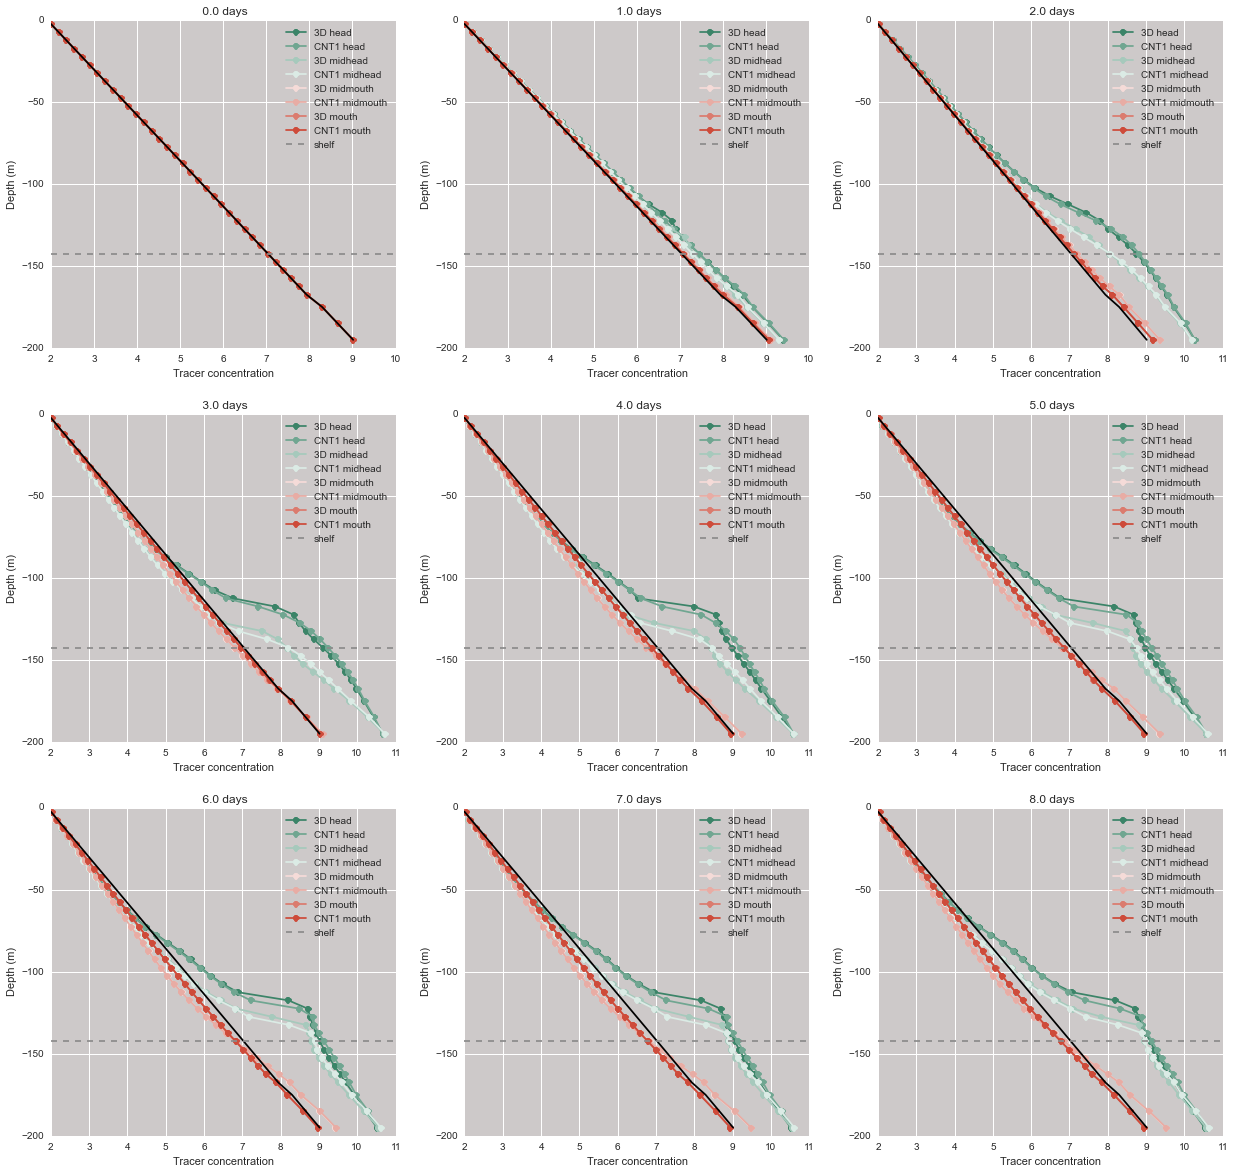

In [113]:
ProfilesAlong(Tr13D,MaskC,Tr13D, Tr1CNT,z, '3D','CNT1','Tracer concentration')

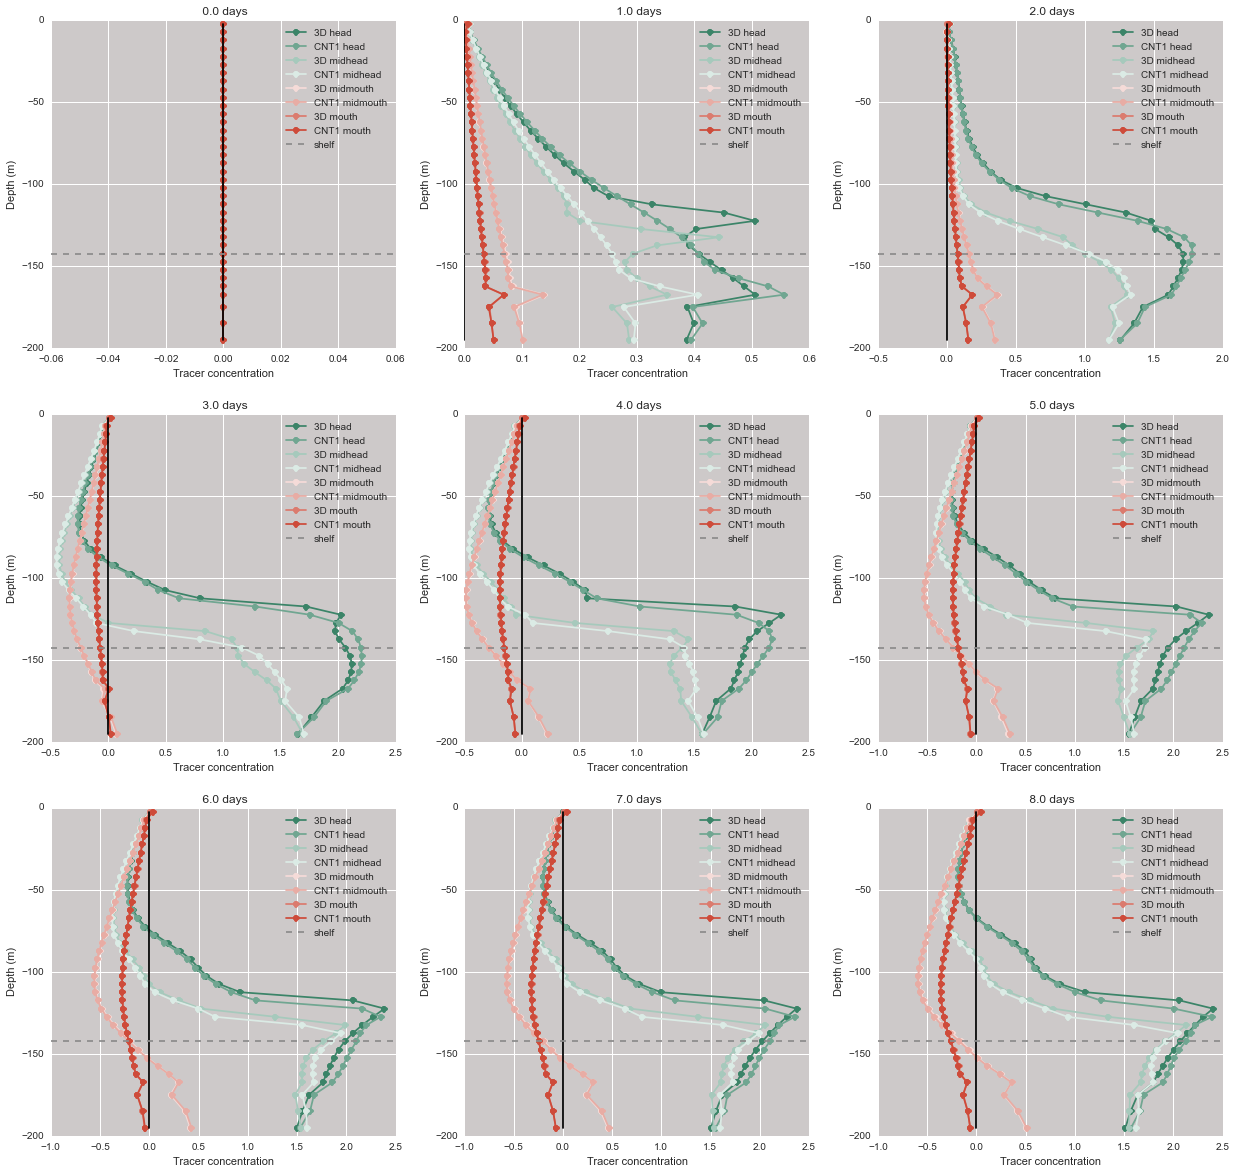

In [114]:
ProfilesAlongAnom(Tr13D,MaskC,Tr13D, Tr1CNT,z, '3D','CNT1','Tracer concentration')

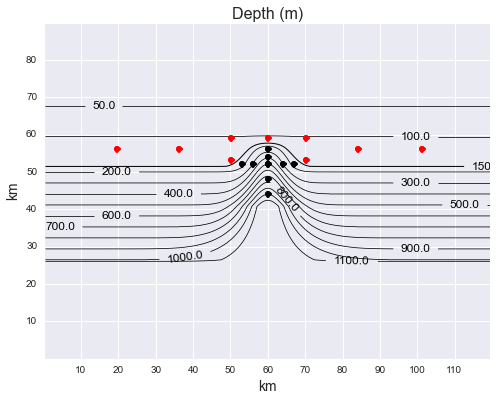

In [142]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(8,6))

### across canyon profiles ###
plt.plot(xc[200,200],yc[200,200],'ko')
plt.plot(xc[200,160],yc[200,160],'ko')
plt.plot(xc[200,180],yc[200,180],'ko')
plt.plot(xc[200,215],yc[200,215],'ko')
plt.plot(xc[200,145],yc[200,145],'ko')
        
### along canyon profiles ###
plt.plot(xc[200,180],yc[200,180],'ko')
plt.plot(xc[210,180],yc[210,180],'ko')
plt.plot(xc[220,180],yc[220,180],'ko')
plt.plot(xc[180,180],yc[180,180],'ko')
plt.plot(xc[160,180],yc[160,180],'ko')

### shelf profiles ###
plt.plot(xc[205,130],yc[205,130],'ro')
plt.plot(xc[205,230],yc[205,230],'ro')
plt.plot(xc[235,180],yc[235,180],'ro')
plt.plot(xc[235,230],yc[235,230],'ro')
plt.plot(xc[235,130],yc[235,130],'ro')
plt.plot(xc[220,300],yc[220,300],'ro')
plt.plot(xc[220,340],yc[220,340],'ro')
plt.plot(xc[220,60],yc[220,60],'ro')
plt.plot(xc[220,20],yc[220,20],'ro')

lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=12)



plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)




#plt.savefig('AcrossShoreLines.png', bbox_inches='tight')
#plt.savefig('AcrossShoreLines.pdf', bbox_inches='tight')

In [115]:
def ProfilesOutsideRhoAnom(Tempa,Tempb,Salta,Saltb,MaskC,RhoRefa,RhoRefb,z,label1,label2,xlabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    TempMaskb=np.ma.array(Tempb[0,:37,230,180],mask=MaskC[:37,230,180])
    SaltMaskb=np.ma.array(Saltb[0,:37,230,180],mask=MaskC[:37,230,180])
    sigmaIni = RhoRefb[:37]*(Bs*SaltMaskb - At*TempMaskb )


    with sns.diverging_palette(220, 20, n=10, center="light") :

        for tt in range(2,19,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TempMaskb=np.ma.array(Tempb[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaskb=np.ma.array(Saltb[tt,:,:,:],mask=MaskC[:,:,:])
            TempMaska=np.ma.array(Tempa[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaska=np.ma.array(Salta[tt,:,:,:],mask=MaskC[:,:,:])

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,130] - At*TempMaskb[:,205,130] )
            plt.plot(sigmab[:37]-sigmaIni,z[:37],'o-',label=('%s MouthUp' %label2))
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,130] - At*TempMaska[:,205,130] )
            plt.plot(sigmaa[:37]-sigmaIni,z[:37],'o-',label=('%s MouthUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,130] - At*TempMaskb[:,235,130] )
            plt.plot(sigmab[:37]-sigmaIni[:37],z[:37],'o-',label=('%s HeadUp' %label2))
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,130] - At*TempMaska[:,235,130] )
            plt.plot(sigmaa[:37]-sigmaIni[:37],z[:37],'o-',label=('%s HeadUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,180] - At*TempMaskb[:,235,180] )
            plt.plot(sigmab[:37]-sigmaIni,z[:37],'o-',label=('%s Head' %label2))
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,180] - At*TempMaska[:,235,180] )
            plt.plot(sigmaa[:37]-sigmaIni,z[:37],'o-',label=('%s Head' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,230] - At*TempMaskb[:,235,230] )
            plt.plot(sigmab[:37]-sigmaIni[:37],z[:37],'o-',label=('%s HeadDn' %label2))
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,230] - At*TempMaska[:,235,230] )
            plt.plot(sigmaa[:37]-sigmaIni[:37],z[:37],'o-',label=('%s HeadDn' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,230] - At*TempMaskb[:,205,230] )
            plt.plot(sigmab[:37]-sigmaIni,z[:37],'o-',label=('%s MouthDn' %label2))
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,230] - At*TempMaska[:,205,230] )
            plt.plot(sigmaa[:37]-sigmaIni,z[:37],'o-',label=('%s MouthDn' %label1))

            plt.plot(sigmaIni-sigmaIni,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
     

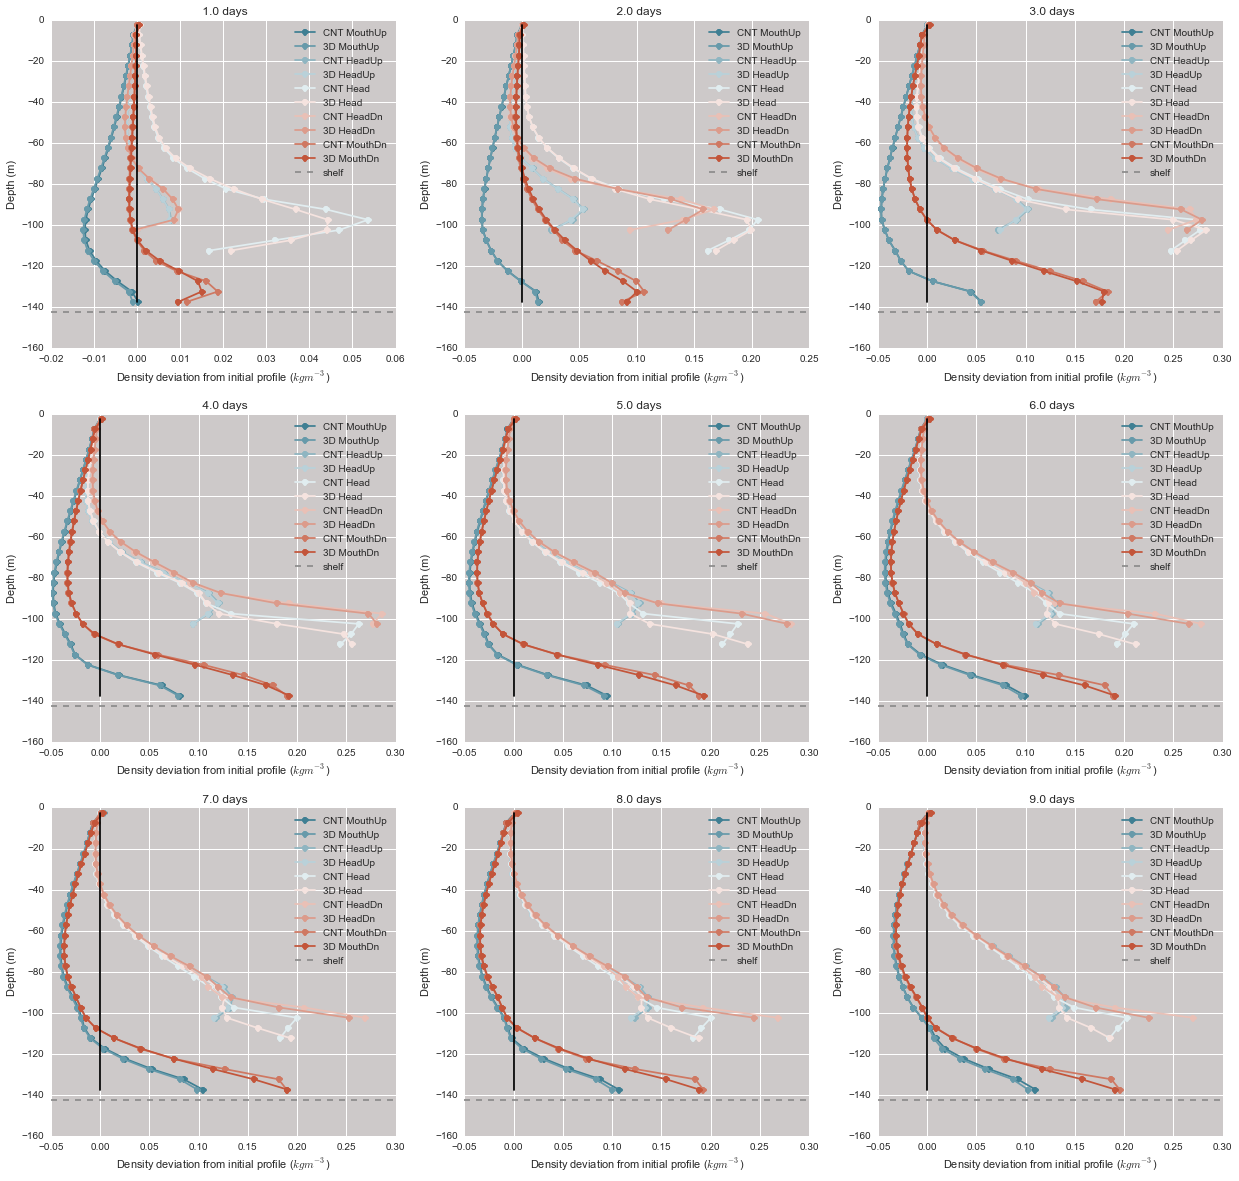

In [116]:
ProfilesOutsideRhoAnom(Tempa,Tempb,Salta,Saltb,MaskC,RhoRefa,RhoRefb,z,'3D','CNT','Density deviation from initial profile ($kg m^{-3}$)')

In [117]:
def ProfilesOutside(IniProfArray,MaskC,Tr1,Tr2,z,label1,label2,xlabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    IniProf=np.ma.array(Tr1[0,:37,230,180],mask=MaskC[:37,230,180])

    with sns.diverging_palette(154, 16, n=10, center="light") :

        for tt in range(0,18,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            Tr1mask=np.ma.array(Tr1[tt,:,:,:],mask=MaskC[:,:,:])
            Tr2mask=np.ma.array(Tr2[tt,:,:,:],mask=MaskC[:,:,:])

            plt.plot(Tr1mask[:37,205,130],z[:37],'o-',label=('%s MouthUp' %label1))
            plt.plot(Tr2mask[:37,205,130],z[:37],'o-',label=('%s MouthUp' %label2))

            plt.plot(Tr1mask[:37,235,130],z[:37],'o-',label=('%s HeadUp' %label1))
            plt.plot(Tr2mask[:37,235,130],z[:37],'o-',label=('%s HeadUp' %label2))

            plt.plot(Tr1mask[:37,235,180],z[:37],'o-',label=('%s Head' %label1))
            plt.plot(Tr2mask[:37,235,180],z[:37],'o-',label=('%s Head' %label2))

            plt.plot(Tr1mask[:37,235,230],z[:37],'o-',label=('%s HeadDn' %label1))
            plt.plot(Tr2mask[:37,235,230],z[:37],'o-',label=('%s HeadDn' %label2))

            plt.plot(Tr1mask[:37,205,230],z[:37],'o-',label=('%s MouthDn' %label1))
            plt.plot(Tr2mask[:37,205,230],z[:37],'o-',label=('%s MouthDn' %label2))

            plt.plot(IniProf,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel('Depth (m)')
            plt.xlabel(xlabel)

            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
   

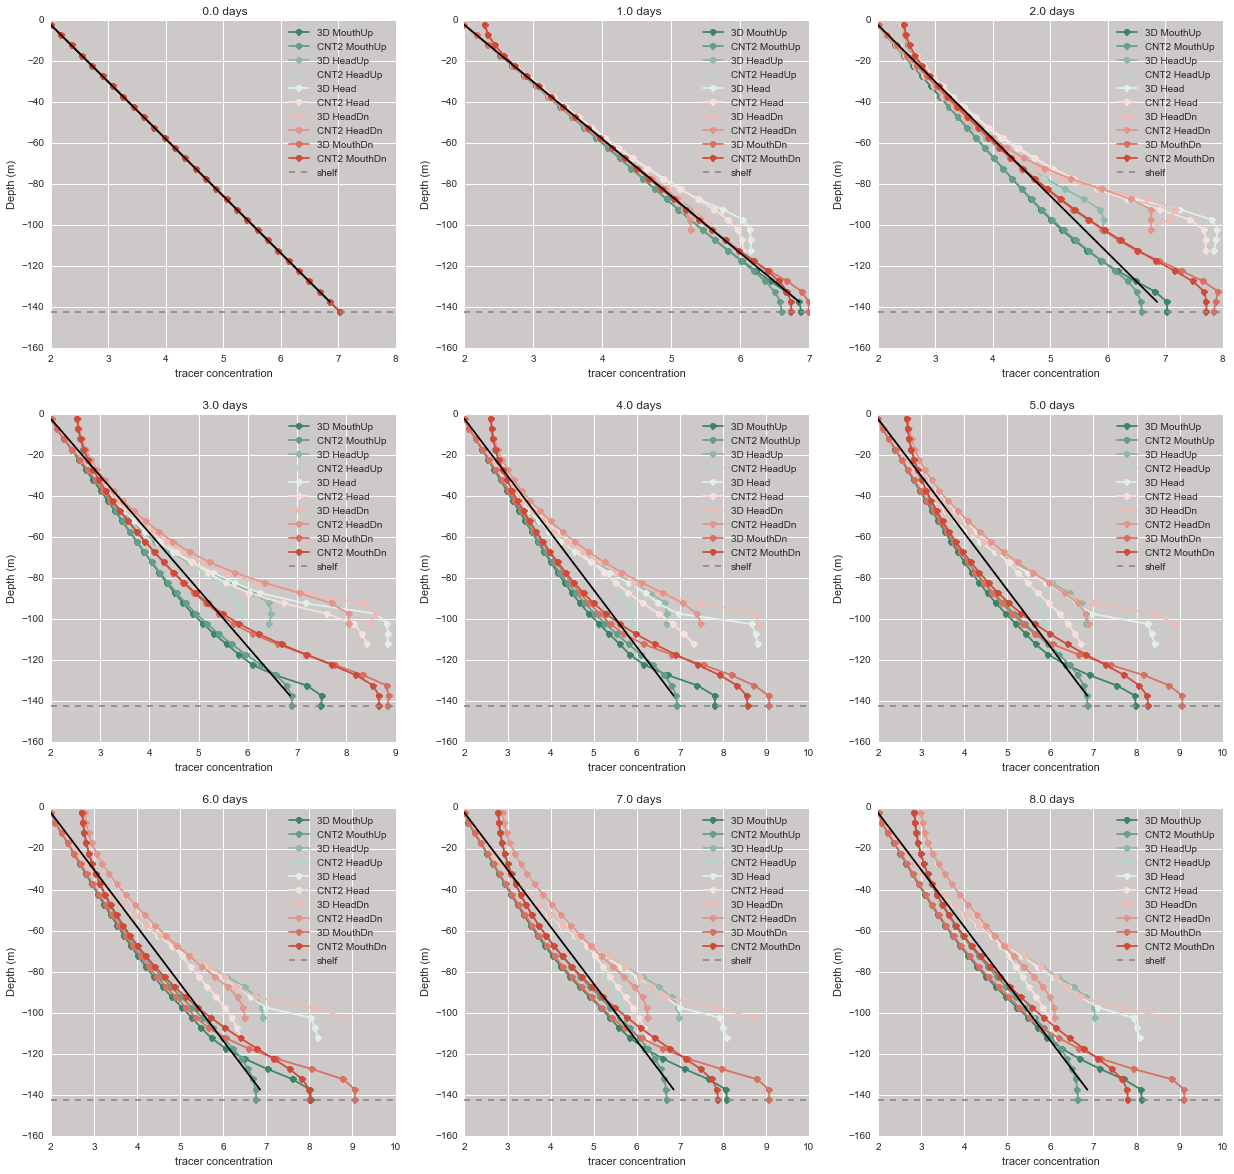

In [118]:
ProfilesOutside(Tr13D,MaskC,Tr13D,Tr2CNT,z,'3D','CNT2','tracer concentration')

### Profiles subtracting stratified, no canyon case

This means that we are only looking at the effect of the canyon. The no canyon case is run 17 (stratified, no canyon, constant diffusivity). 

In [91]:
filename1c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/stateGlob.nc'
StateOutc = Dataset(filename1c)

filename2c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/gridGlob.nc'
GridOutc = Dataset(filename2c)

filename3c='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/ptracersGlob.nc'
PtracersOutc = Dataset(filename3c)

RhoRefc = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/RhoRef'))


/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_8Tr_LinProfiles_BarkleyHyd_GMREDI/run17/RhoRef.meta


In [286]:
Tr1NoC = rout.getField(filename3c,'Tr1')
Tr2NoC = rout.getField(filename3c,'Tr2')

TempNoC = rout.getField(filename1c,'Temp')
SaltNoC = rout.getField(filename1c,'S')

MaskNoC = rout.getMask(filename2c,'HFacC') 
hFacCNoC = rout.getField(filename2c,'HFacC') 
rANoC = rout.getField(filename2c,'rA') 

In [305]:
drFNoC= GridOutc.variables['drF']

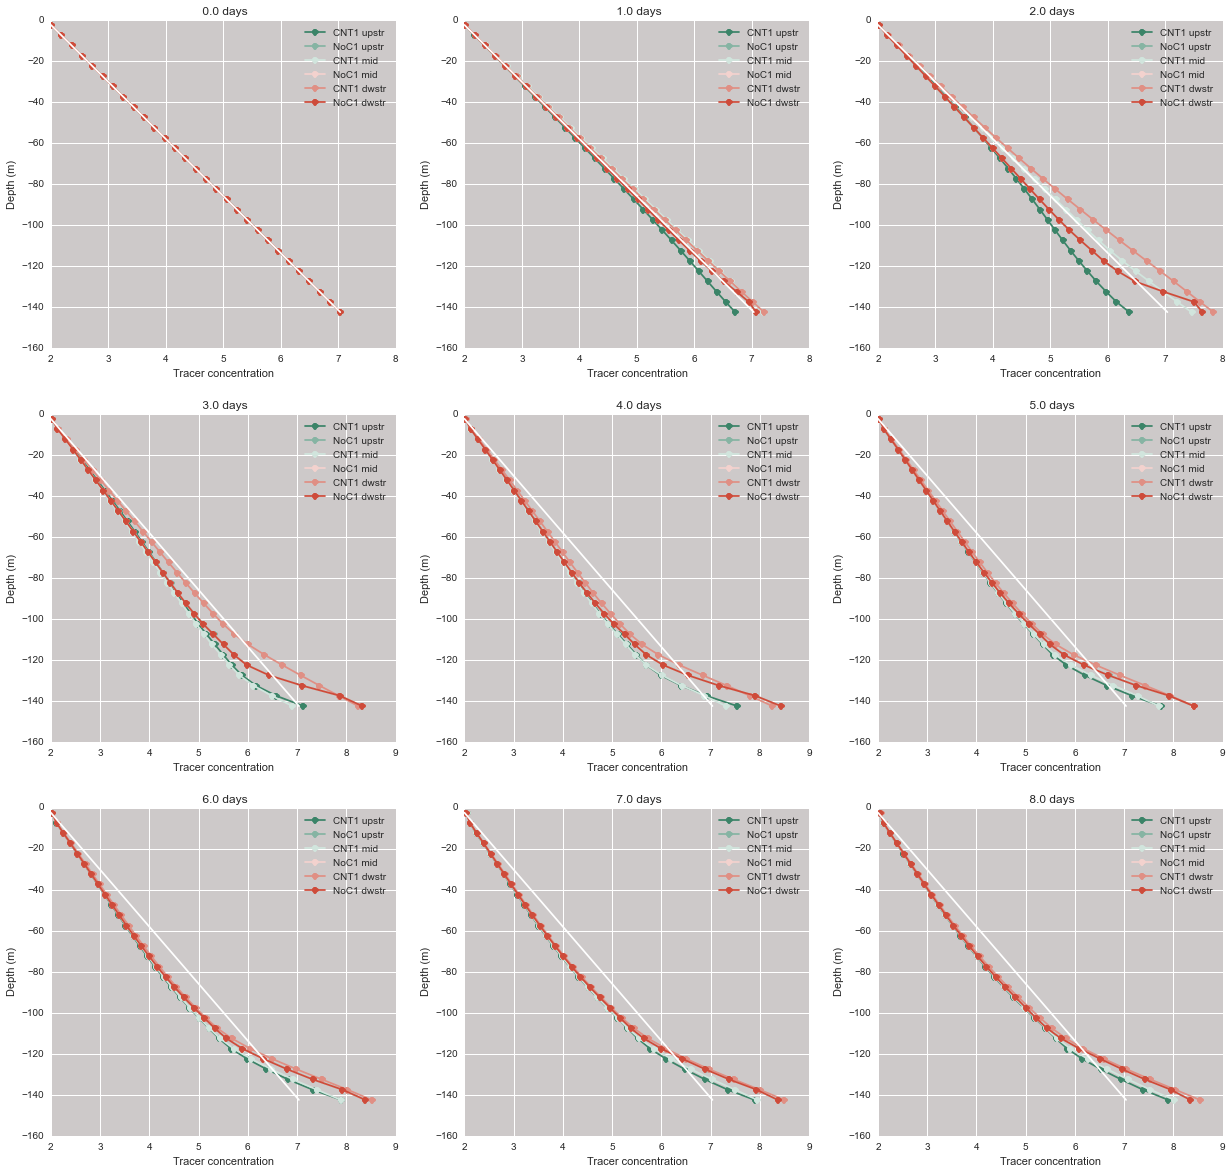

In [130]:
ProfilesAcross(Tr1CNT, MaskNoC,Tr1CNT,Tr1NoC,z, 'CNT1', 'NoC1','Tracer concentration')

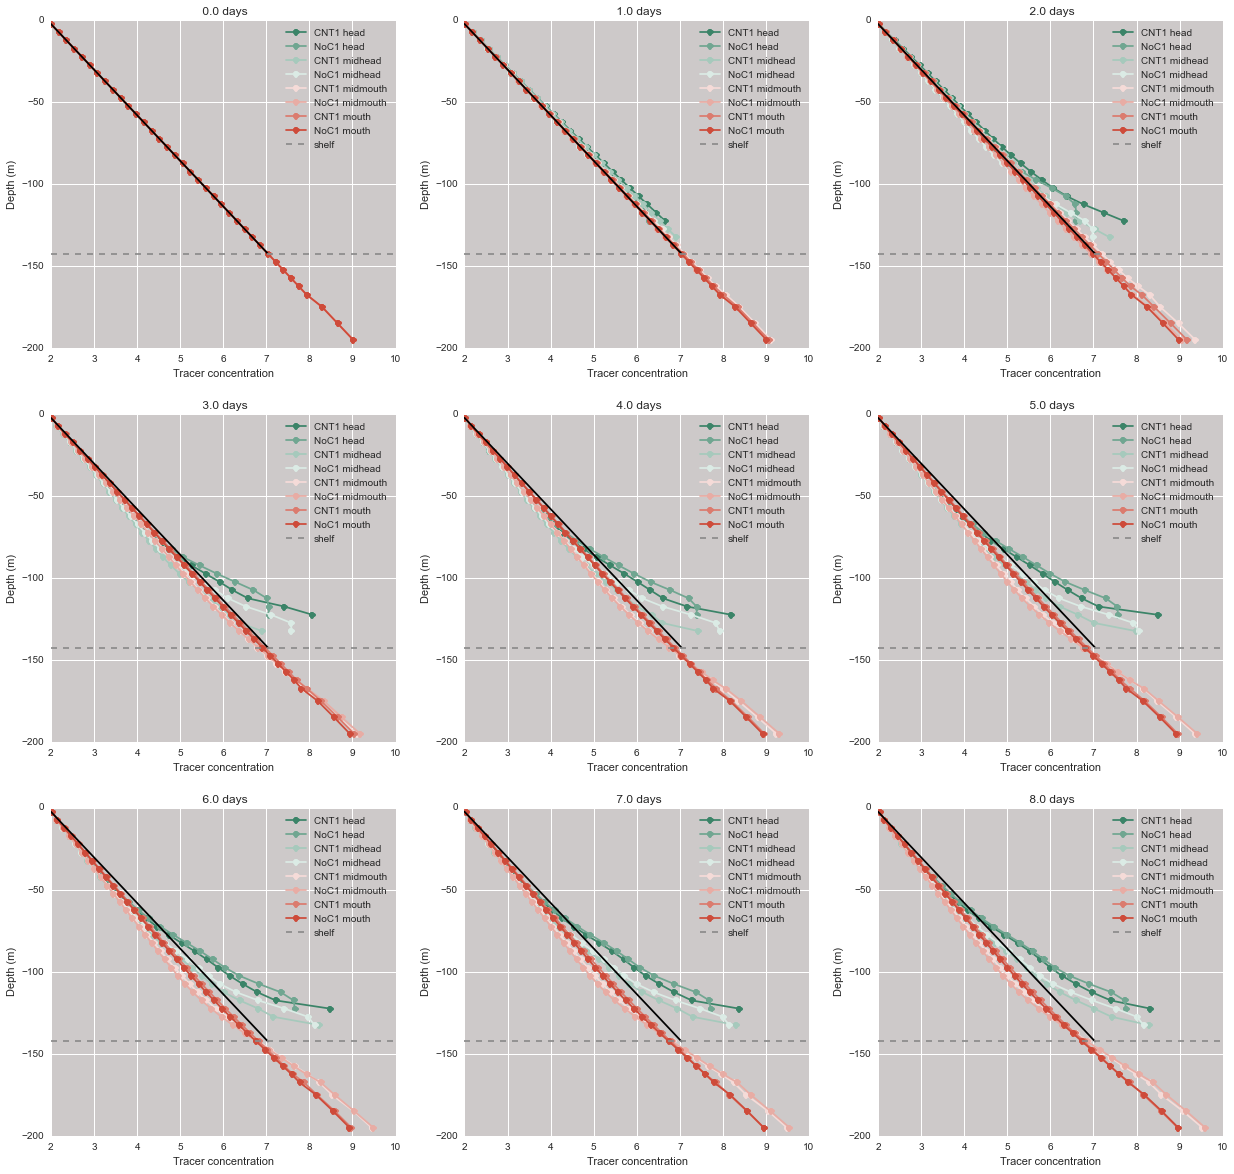

In [131]:
ProfilesAlong(Tr1CNT, MaskNoC,Tr1CNT,Tr1NoC,z, 'CNT1', 'NoC1','Tracer concentration')



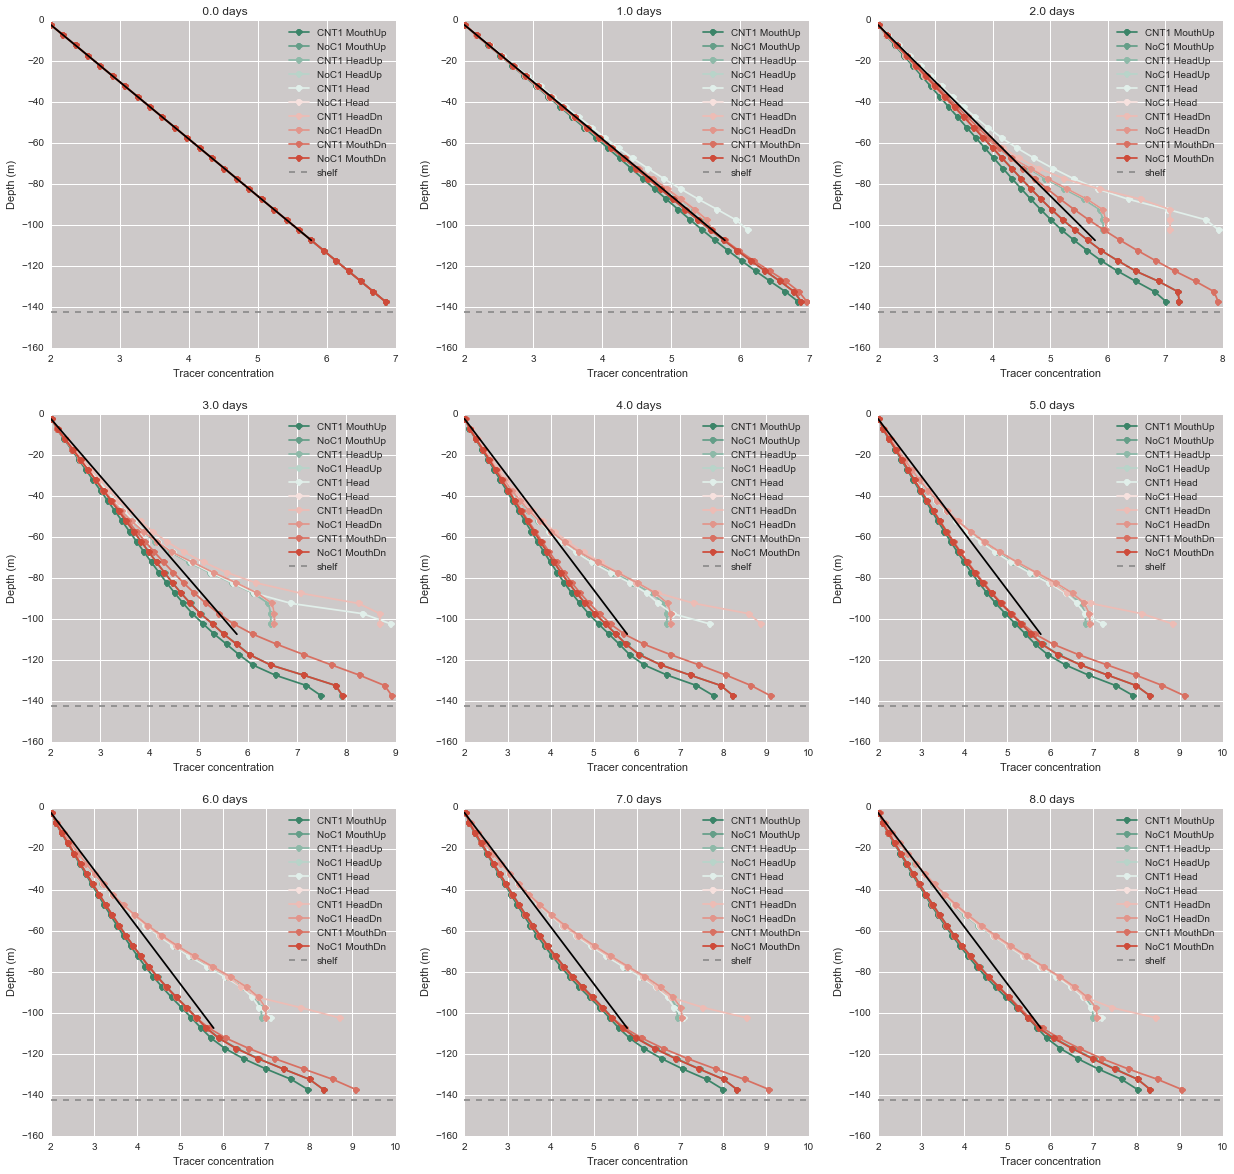

In [132]:
ProfilesOutside(Tr1CNT, MaskNoC,Tr1CNT,Tr1NoC,z, 'CNT1', 'NoC1','Tracer concentration')


In [151]:
def ProfilesOutsideAnomNoCanyon(TrNoCan,Tr1,MaskC,z,label1,xlabel,ylabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1

    with sns.diverging_palette(220, 20, n=9, center="light") :

        for tt in range(2,19,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TrNoCanMask=np.ma.array(TrNoCan[tt,:,:,:],mask=MaskC[:,:,:])
            Tr1Mask=np.ma.array(Tr1[tt,:,:,:],mask=MaskC[:,:,:])
            
            plt.plot(Tr1Mask[:37,220,20]-TrNoCanMask[:37,220,20],z[:37],'o-',label=('%s MidShUpBd' %label1))
            
            plt.plot(Tr1Mask[:37,220,60]-TrNoCanMask[:37,220,60],z[:37],'o-',label=('%s MidShUp' %label1))
            
            plt.plot(Tr1Mask[:37,205,130]-TrNoCanMask[:37,205,130],z[:37],'o-',label=('%s MouthUp' %label1))
            
            plt.plot(Tr1Mask[:37,235,130]-TrNoCanMask[:37,235,130],z[:37],'o-',label=('%s HeadUp' %label1))
            
            plt.plot(Tr1Mask[:37,235,180]-TrNoCanMask[:37,235,180],z[:37],'o-',label=('%s Head' %label1))
            
            plt.plot(Tr1Mask[:37,235,230]-TrNoCanMask[:37,235,230],z[:37],'o-',label=('%s HeadDn' %label1))
            
            plt.plot(Tr1Mask[:37,205,230]-TrNoCanMask[:37,205,230],z[:37],'o-',label=('%s MouthDn' %label1))
            
            plt.plot(Tr1Mask[:37,220,300]-TrNoCanMask[:37,220,300],z[:37],'o-',label=('%s MidShDn' %label1))
            
            plt.plot(Tr1Mask[:37,220,340]-TrNoCanMask[:37,220,340],z[:37],'o-',label=('%s MidShDnBd' %label1))
            

            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')
            plt.xlim(xmax = 2.0, xmin = -0.7)

            plt.ylabel(ylabel)
            plt.xlabel(xlabel)
            

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
     

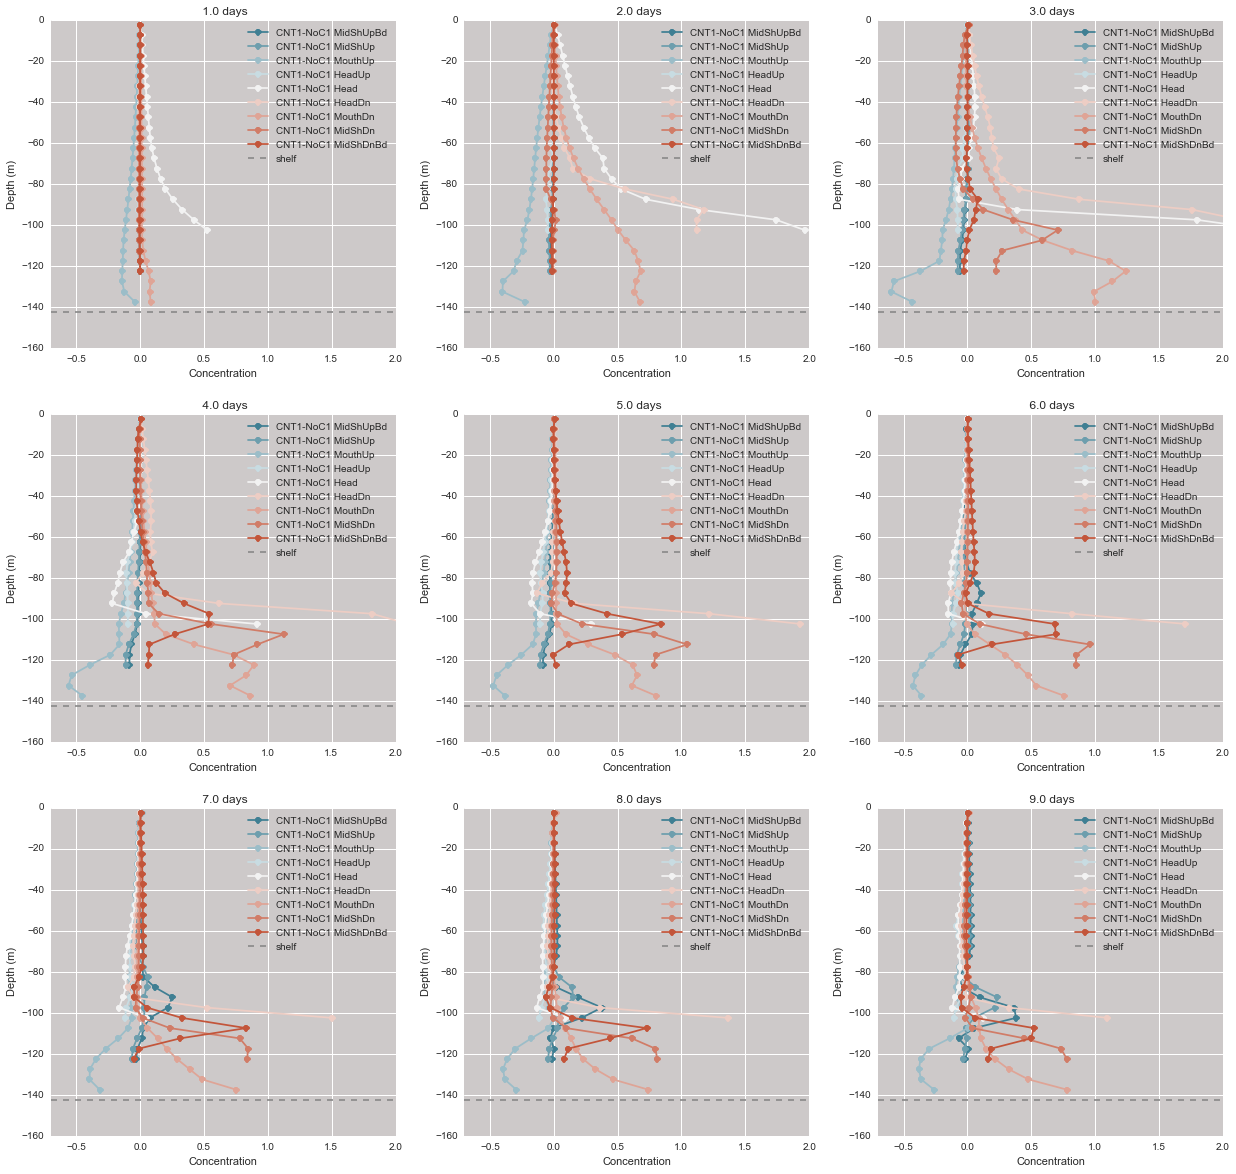

In [152]:
ProfilesOutsideAnomNoCanyon(Tr1NoC,Tr1CNT,MaskNoC,z,'CNT1-NoC1','Concentration','Depth (m)')

In [157]:
def ProfilesOutsideRhoAnom(Tempa,Tempb,Salta,Saltb,MaskC,RhoRefa,RhoRefb,z,label1,xlabel,ylabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1
    
    with sns.diverging_palette(220, 20, n=10, center="light") :

        for tt in range(2,19,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TempMaskb=np.ma.array(Tempb[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaskb=np.ma.array(Saltb[tt,:,:,:],mask=MaskC[:,:,:])
            TempMaska=np.ma.array(Tempa[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaska=np.ma.array(Salta[tt,:,:,:],mask=MaskC[:,:,:])

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,20] - At*TempMaskb[:,220,20] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,20] - At*TempMaska[:,220,20] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MidShUpBd' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,60] - At*TempMaskb[:,220,60] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,60] - At*TempMaska[:,220,60] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MidShUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,130] - At*TempMaskb[:,205,130] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,130] - At*TempMaska[:,205,130] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MouthUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,130] - At*TempMaskb[:,235,130] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,130] - At*TempMaska[:,235,130] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s HeadUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,180] - At*TempMaskb[:,235,180] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,180] - At*TempMaska[:,235,180] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s Head' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,230] - At*TempMaskb[:,235,230] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,230] - At*TempMaska[:,235,230] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s HeadDn' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,230] - At*TempMaskb[:,205,230] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,230] - At*TempMaska[:,205,230] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MouthDn' %label1))
            
            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,300] - At*TempMaskb[:,220,300] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,300] - At*TempMaska[:,220,300] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MidShDn' %label1))
            
            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,340] - At*TempMaskb[:,220,340] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,340] - At*TempMaska[:,220,340] )
            plt.plot(sigmaa[:37]-sigmab[:37],z[:37],'o-',label=('%s MidShDnBd' %label1))


            plt.plot(sigmaIni-sigmaIni,z[:37],'-k')
            plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel(ylabel)
            plt.xlabel(xlabel)

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend()

            kk=kk+1
     

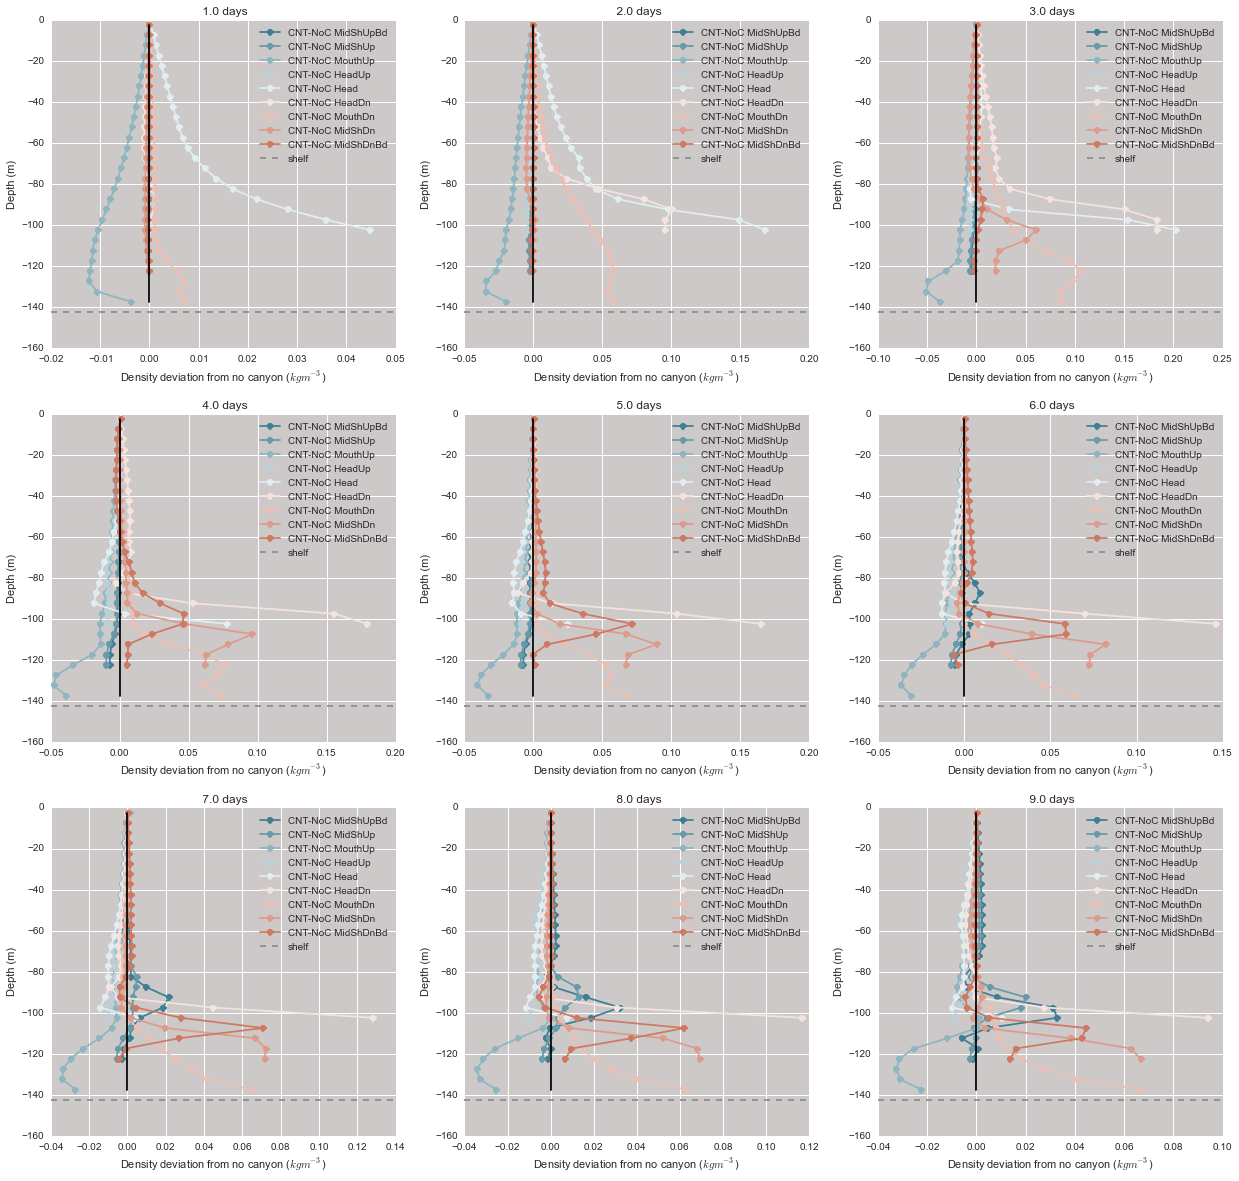

In [158]:
ProfilesOutsideRhoAnom(Tempa,TempNoC,Salta,SaltNoC,MaskNoC,RhoRefa,RhoRefc,z,'CNT-NoC','Density deviation from no canyon ($kg m^{-3}$)','Depth (m)')

In [200]:
from scipy import stats
def RhoTracerOutsideAnom(Tempa,Tempb,Salta,Saltb,Tra,Trb,MaskC,RhoRefa,RhoRefb,label1,xlabel,ylabel):
    # Profiles
    fig45=plt.figure(figsize=(21,20))
    sns.set_style('darkgrid')

    kk=1
    
    with sns.diverging_palette(220, 20, n=10, center="light") :

        for tt in range(2,19,2) :

            plt.subplot(3,3,kk)
            ax = plt.gca()
            ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

            TempMaskb=np.ma.array(Tempb[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaskb=np.ma.array(Saltb[tt,:,:,:],mask=MaskC[:,:,:])
            TempMaska=np.ma.array(Tempa[tt,:,:,:],mask=MaskC[:,:,:])
            SaltMaska=np.ma.array(Salta[tt,:,:,:],mask=MaskC[:,:,:])
            TrbMask=np.ma.array(Trb[tt,:,:,:],mask=MaskC[:,:,:])
            TraMask=np.ma.array(Tra[tt,:,:,:],mask=MaskC[:,:,:])
            
            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,20] - At*TempMaskb[:,220,20] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,20] - At*TempMaska[:,220,20] )
            plt.plot(TraMask[:37,220,20]-TrbMask[:37,220,20],sigmaa[:37]-sigmab[:37],'o-',label=('%s MidShUpBd' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,60] - At*TempMaskb[:,220,60] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,60] - At*TempMaska[:,220,60] )
            plt.plot(TraMask[:37,220,60]-TrbMask[:37,220,60],sigmaa[:37]-sigmab[:37],'o-',label=('%s MidShUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,130] - At*TempMaskb[:,205,130] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,130] - At*TempMaska[:,205,130] )
            plt.plot(TraMask[:37,205,130]-TrbMask[:37,205,130],sigmaa[:37]-sigmab[:37],'o-',label=('%s MouthUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,130] - At*TempMaskb[:,235,130] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,130] - At*TempMaska[:,235,130] )
            plt.plot(TraMask[:37,235,130]-TrbMask[:37,235,130],sigmaa[:37]-sigmab[:37],'o-',label=('%s HeadUp' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,180] - At*TempMaskb[:,235,180] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,180] - At*TempMaska[:,235,180] )
            plt.plot(TraMask[:37,235,180]-TrbMask[:37,235,180],sigmaa[:37]-sigmab[:37],'o-',label=('%s Head' %label1))
            slope, intercept, r_value, p_value, std_err = stats.linregress(TraMask[:37,235,180]-TrbMask[:37,235,180],sigmaa[:37]-sigmab[:37])
            print('slope = %f, intercept = %f, r_value = %f, p_value = %f, std_err = %f ' %(slope, intercept, r_value, p_value, std_err))
            

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,235,230] - At*TempMaskb[:,235,230] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,235,230] - At*TempMaska[:,235,230] )
            plt.plot(TraMask[:37,235,230]-TrbMask[:37,235,230],sigmaa[:37]-sigmab[:37],'o-',label=('%s HeadDn' %label1))

            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,205,230] - At*TempMaskb[:,205,230] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,205,230] - At*TempMaska[:,205,230] )
            plt.plot(TraMask[:37,205,230]-TrbMask[:37,205,230],sigmaa[:37]-sigmab[:37],'o-',label=('%s MouthDn' %label1))
            slope, intercept, r_value, p_value, std_err = stats.linregress(TraMask[:37,205,230]-TrbMask[:37,205,230],sigmaa[:37]-sigmab[:37])
            print('slope = %f, intercept = %f, r_value = %f, p_value = %f, std_err = %f ' %(slope, intercept, r_value, p_value, std_err))
            
            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,300] - At*TempMaskb[:,220,300] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,300] - At*TempMaska[:,220,300] )
            plt.plot(TraMask[:37,220,300]-TrbMask[:37,220,300],sigmaa[:37]-sigmab[:37],'o-',label=('%s MidShDn' %label1))
            
            sigmab = RhoRefb[:]*(Bs*SaltMaskb[:,220,340] - At*TempMaskb[:,220,340] )
            sigmaa = RhoRefa[:]*(Bs*SaltMaska[:,220,340] - At*TempMaska[:,220,340] )
            plt.plot(TraMask[:37,220,340]-TrbMask[:37,220,340],sigmaa[:37]-sigmab[:37],'o-',label=('%s MidShDnBd' %label1))


            
            #plt.axhline(y=z[28],linestyle='--', color='0.55',label='shelf')


            plt.ylabel(ylabel)
            plt.xlabel(xlabel)

            #labels = [40, 50, 60, 70, 80]
                #plt.xticks([40000,50000,60000,70000,80000], labels)
            plt.title(" %1.1f days " % (tt/2.))
            plt.legend(loc=4)

            kk=kk+1
     

slope = 5.214173, intercept = -0.381835, r_value = 0.996314, p_value = 0.000000, std_err = 0.075882 
slope = 4.597708, intercept = -0.072296, r_value = 0.999814, p_value = 0.000000, std_err = 0.014973 
slope = 3.946227, intercept = -0.903128, r_value = 0.969348, p_value = 0.000000, std_err = 0.169066 
slope = 4.029241, intercept = -0.799035, r_value = 0.981904, p_value = 0.000000, std_err = 0.131356 
slope = 3.485060, intercept = -0.374243, r_value = 0.973744, p_value = 0.000000, std_err = 0.137719 
slope = 3.473234, intercept = -0.797872, r_value = 0.966640, p_value = 0.000000, std_err = 0.155566 
slope = 3.642393, intercept = 0.025811, r_value = 0.996608, p_value = 0.000000, std_err = 0.050836 
slope = 3.475035, intercept = -0.485299, r_value = 0.983997, p_value = 0.000000, std_err = 0.106364 
slope = 3.800829, intercept = 0.115554, r_value = 0.998554, p_value = 0.000000, std_err = 0.034588 
slope = 3.471699, intercept = -0.331649, r_value = 0.989856, p_value = 0.000000, std_err = 0.

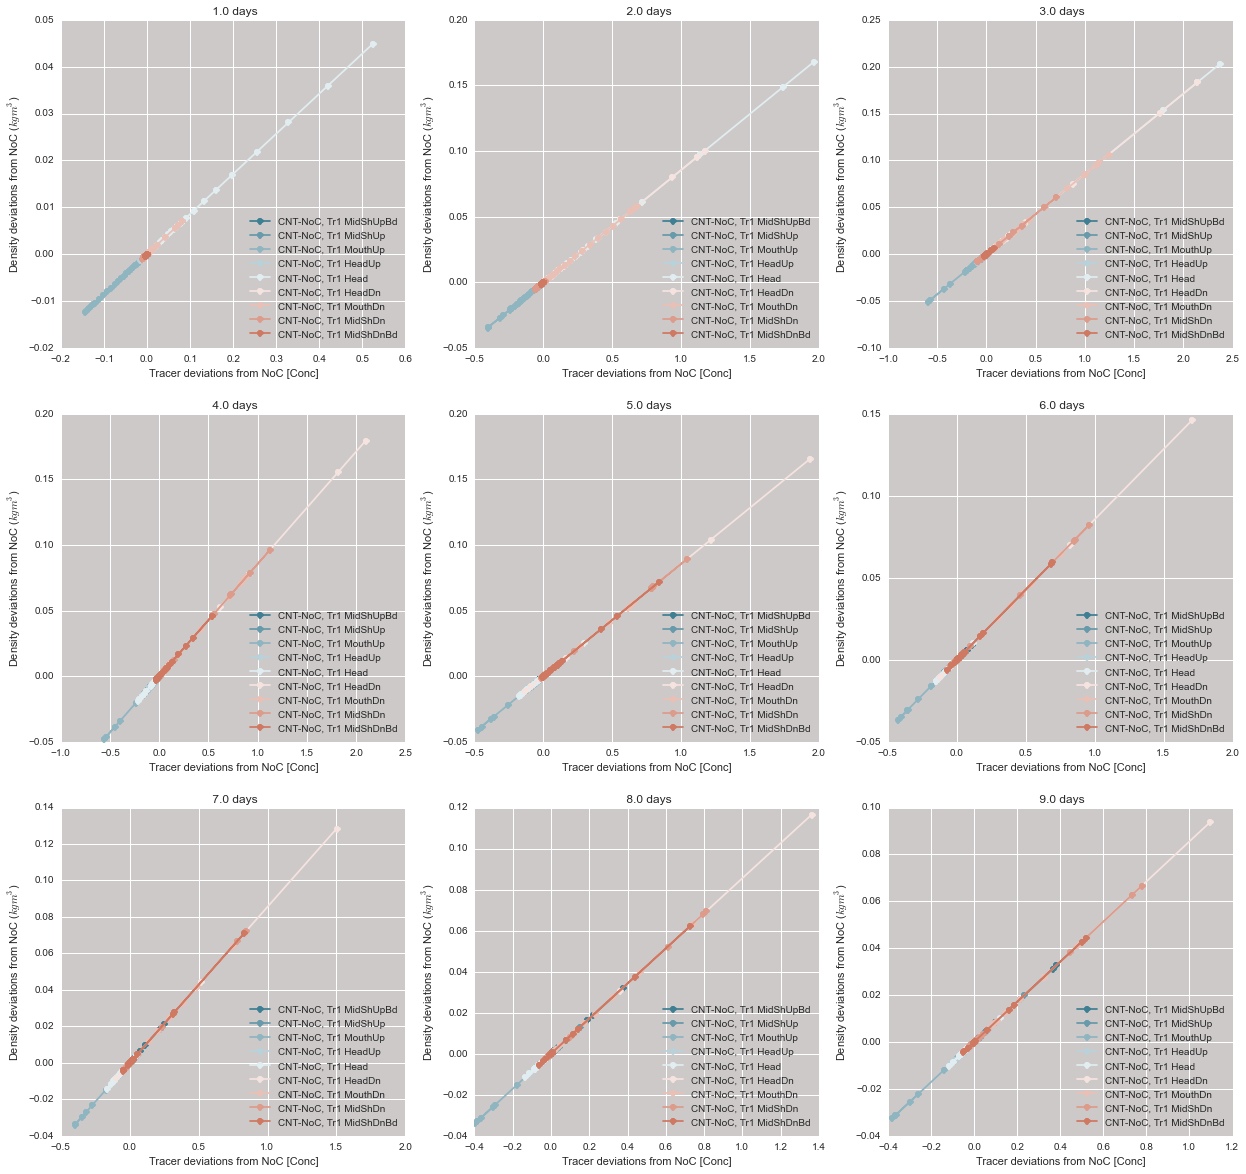

In [201]:
RhoTracerOutsideAnom(Tempa,TempNoC,Salta,SaltNoC,Tr1CNT,Tr1NoC,MaskNoC,RhoRefa,RhoRefc,'CNT-NoC, Tr1','Tracer deviations from NoC [Conc]','Density deviations from NoC ($kg m^{3}$)')



slope = 5.248792, intercept = -0.403331, r_value = 0.995137, p_value = 0.000000, std_err = 0.087815 
slope = 4.614307, intercept = -0.076960, r_value = 0.999678, p_value = 0.000000, std_err = 0.019784 
slope = 3.953029, intercept = -0.939946, r_value = 0.965466, p_value = 0.000000, std_err = 0.180307 
slope = 4.046852, intercept = -0.810652, r_value = 0.979010, p_value = 0.000000, std_err = 0.142404 
slope = 3.499648, intercept = -0.440677, r_value = 0.970761, p_value = 0.000000, std_err = 0.146277 
slope = 3.487659, intercept = -0.810625, r_value = 0.963762, p_value = 0.000000, std_err = 0.163177 
slope = 3.598736, intercept = -0.045364, r_value = 0.987887, p_value = 0.000000, std_err = 0.095549 
slope = 3.485556, intercept = -0.500962, r_value = 0.981160, p_value = 0.000000, std_err = 0.116012 
slope = 3.791421, intercept = 0.035608, r_value = 0.992788, p_value = 0.000000, std_err = 0.077386 
slope = 3.513804, intercept = -0.361800, r_value = 0.986844, p_value = 0.000000, std_err = 0

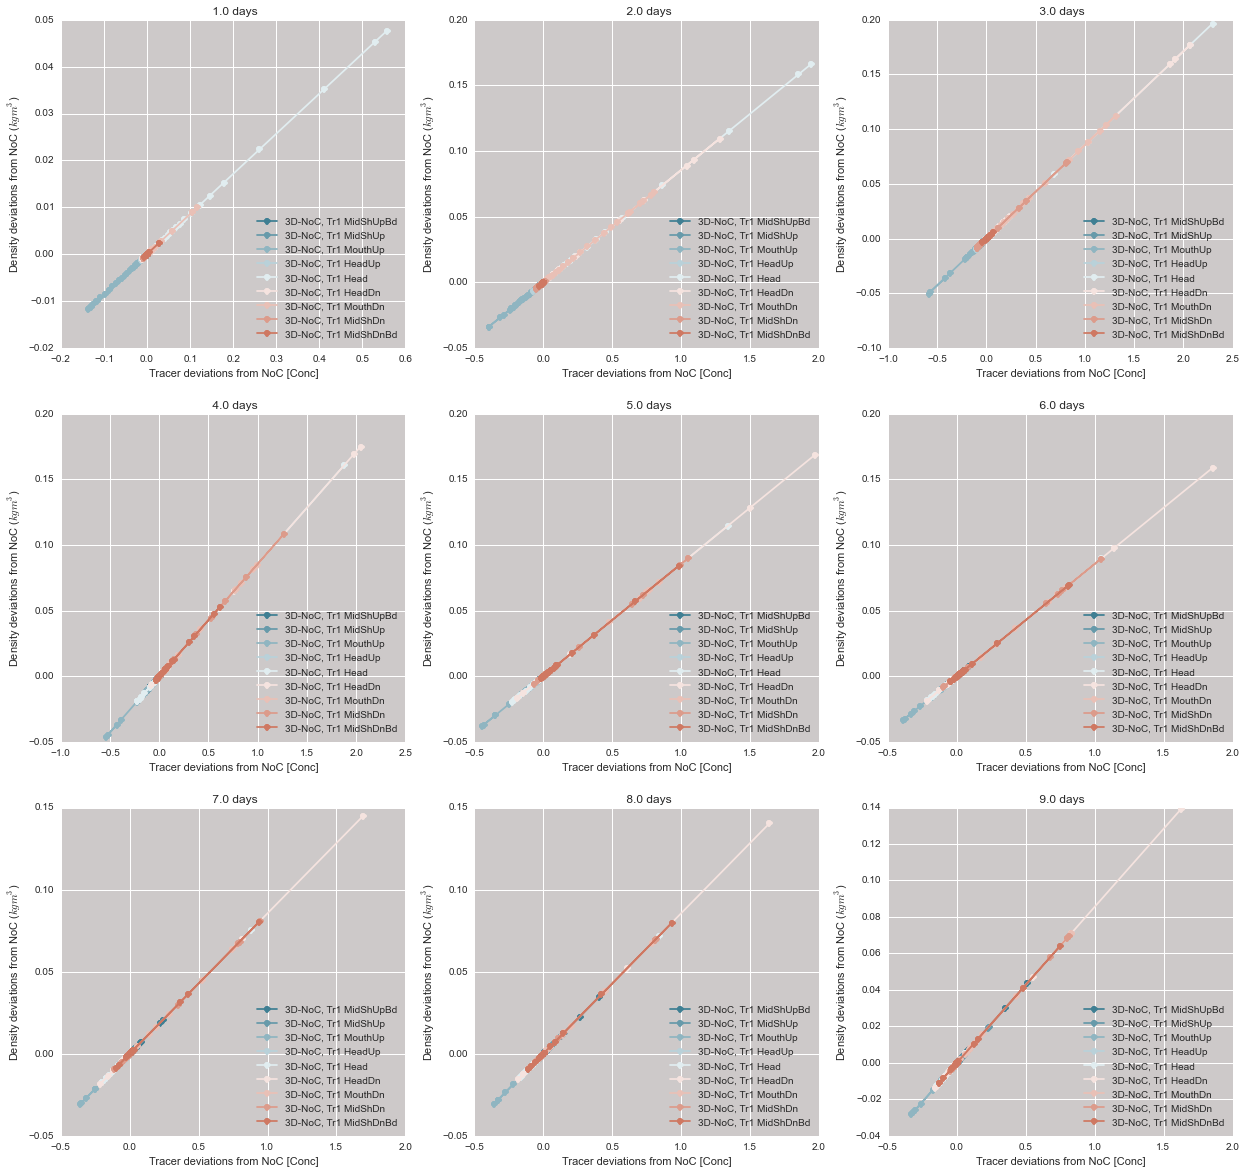

In [202]:
RhoTracerOutsideAnom(Tempb,TempNoC,Saltb,SaltNoC,Tr13D,Tr1NoC,MaskNoC,RhoRefb,RhoRefc,'3D-NoC, Tr1','Tracer deviations from NoC [Conc]','Density deviations from NoC ($kg m^{3}$)')

slope = 4.000158, intercept = 2.808715, r_value = 0.888290, p_value = 0.000000, std_err = 0.349598 
slope = 3.069766, intercept = 5.624764, r_value = 0.816139, p_value = 0.000000, std_err = 0.367390 
slope = 3.110052, intercept = 4.141125, r_value = 0.830843, p_value = 0.000000, std_err = 0.352116 
slope = 2.640809, intercept = 6.683842, r_value = 0.777167, p_value = 0.000000, std_err = 0.361445 
slope = 2.822368, intercept = 4.923619, r_value = 0.794911, p_value = 0.000000, std_err = 0.364128 
slope = 2.329433, intercept = 7.781176, r_value = 0.734270, p_value = 0.000000, std_err = 0.364032 
slope = 3.034034, intercept = 4.526627, r_value = 0.813158, p_value = 0.000000, std_err = 0.367085 
slope = 2.357956, intercept = 7.895910, r_value = 0.729301, p_value = 0.000000, std_err = 0.373915 
slope = 3.122219, intercept = 4.271827, r_value = 0.824802, p_value = 0.000000, std_err = 0.361787 
slope = 2.365803, intercept = 7.938347, r_value = 0.727469, p_value = 0.000000, std_err = 0.377175 


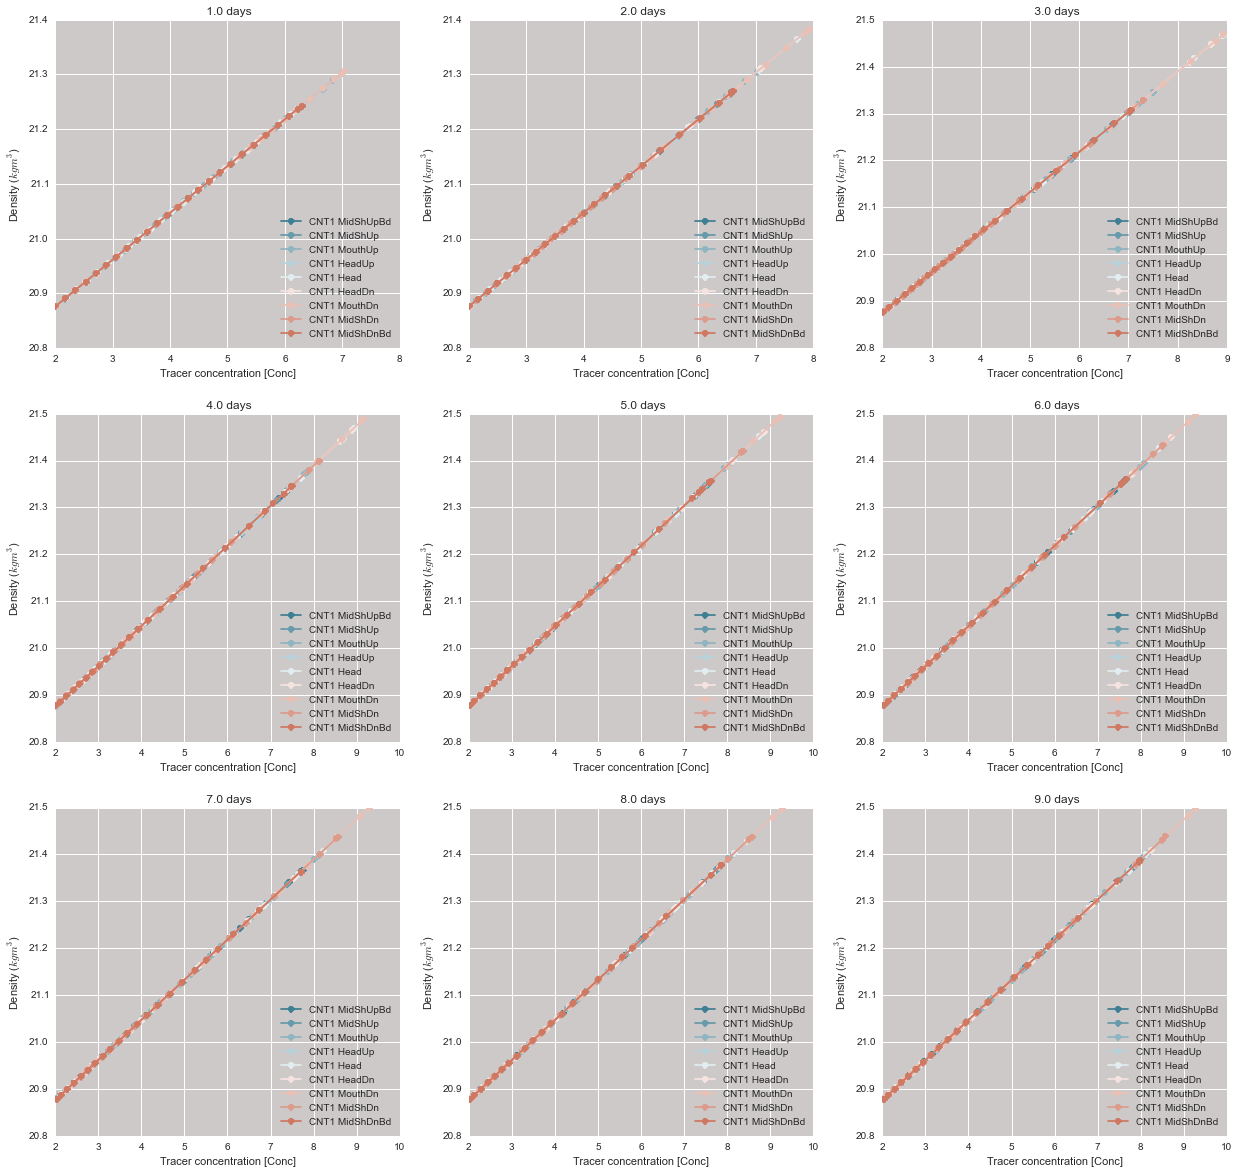

In [203]:
Temp0=np.zeros([19,90,360,360])

Salt0=np.zeros([19,90,360,360])

RhoRef0=np.zeros(len(RhoRefb))


RhoTracerOutsideAnom(Tempa,Temp0,Salta,Salt0,Tr1CNT,Temp0,MaskC,RhoRefa,RhoRef0,'CNT1','Tracer concentration [Conc]','Density ($kg m^{3}$)')

slope = 3.991134, intercept = 2.826257, r_value = 0.887550, p_value = 0.000000, std_err = 0.350185 
slope = 3.065923, intercept = 5.637574, r_value = 0.815673, p_value = 0.000000, std_err = 0.367556 
slope = 3.092128, intercept = 4.167706, r_value = 0.829666, p_value = 0.000000, std_err = 0.351687 
slope = 2.626980, intercept = 6.732725, r_value = 0.775305, p_value = 0.000000, std_err = 0.361729 
slope = 2.799763, intercept = 4.943420, r_value = 0.794031, p_value = 0.000000, std_err = 0.362297 
slope = 2.325632, intercept = 7.791657, r_value = 0.733853, p_value = 0.000000, std_err = 0.363886 
slope = 2.953880, intercept = 4.678462, r_value = 0.806217, p_value = 0.000000, std_err = 0.366395 
slope = 2.346287, intercept = 7.930989, r_value = 0.727887, p_value = 0.000000, std_err = 0.373608 
slope = 3.048069, intercept = 4.414571, r_value = 0.818362, p_value = 0.000000, std_err = 0.361817 
slope = 2.354834, intercept = 7.967904, r_value = 0.726280, p_value = 0.000000, std_err = 0.376731 


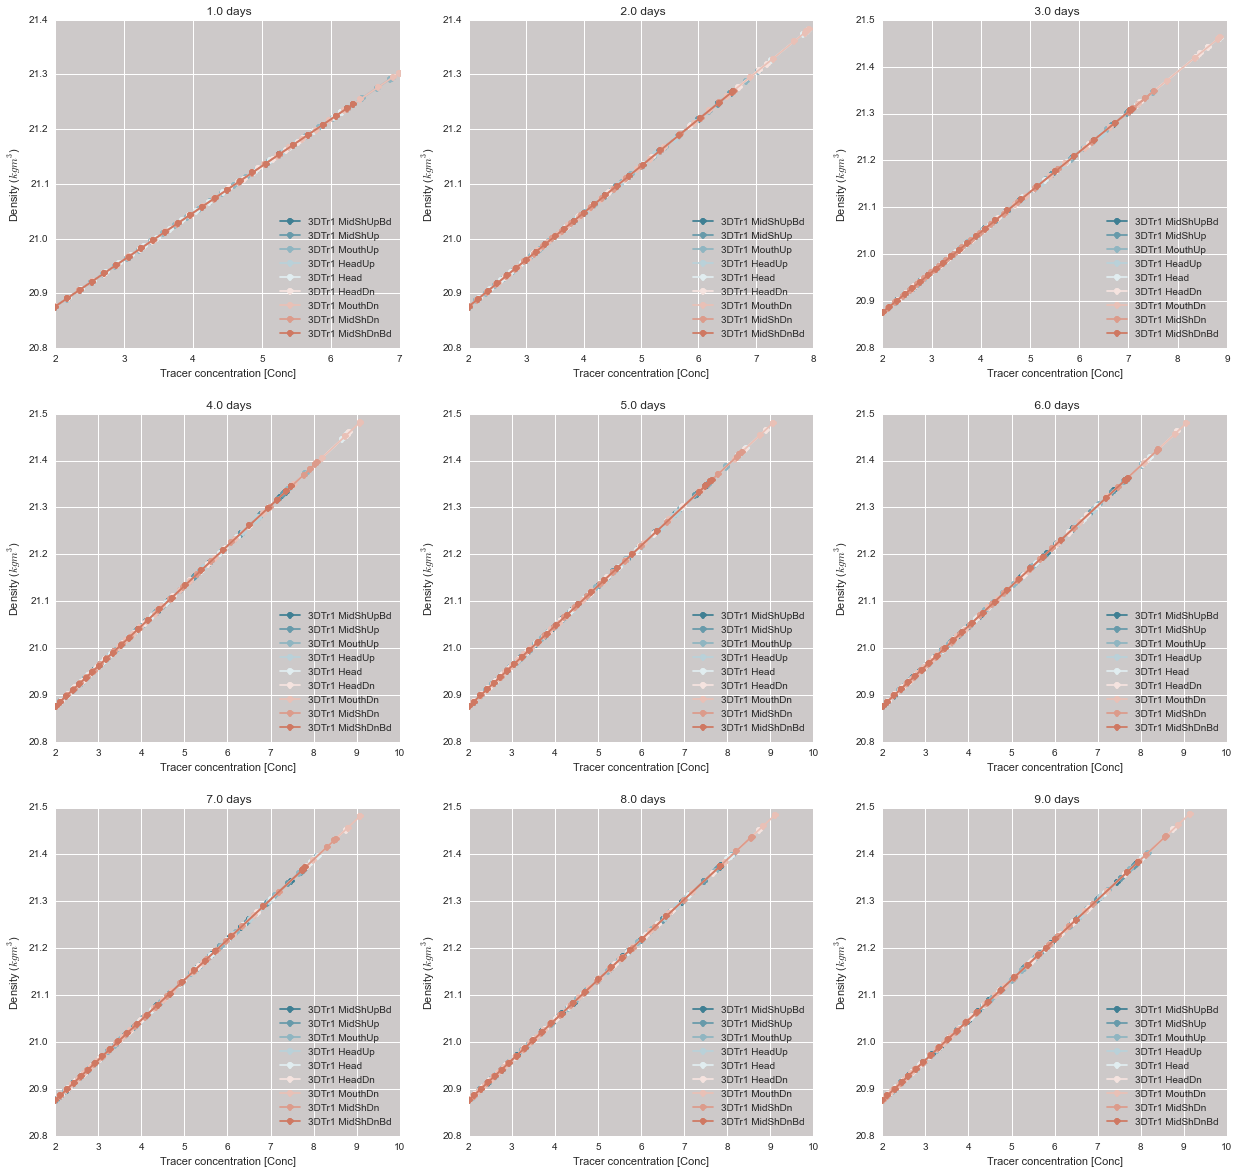

In [205]:
RhoTracerOutsideAnom(Tempb,Temp0,Saltb,Salt0,Tr13D,Temp0,MaskC,RhoRefb,RhoRef0,'3DTr1','Tracer concentration [Conc]','Density ($kg m^{3}$)')




### How much water with tracer concentration >= C[zi=27, x,y in open water] is there on the shelf at a given time? How much water with density >= $\rho$[zi=27, x,y in open water] is there on the shelf at a given time? How much tracer?

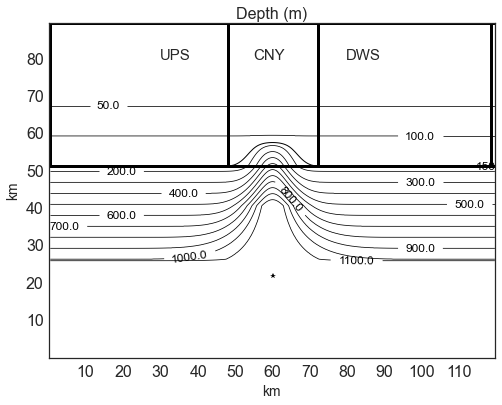

In [390]:
plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(8,6))
sns.set_style('white')
### Across-Shelf Planes ###
plt.plot(xc[197:,120],yc[197:,120],'-', linewidth=3, linestyle='-', color='0.0')
plt.plot(xc[197:,240],yc[197:,240],'-',linewidth=3, linestyle='-', color='0.0' )

### Along Shelf Planes ###
plt.plot(xc[197,:120],yc[197,:120],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197,120:240],yc[197,120:240],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197,240:360],yc[197,240:360],'-',linewidth=3, linestyle='-', color='0.0' )


plt.plot(xc[359,:],yc[359,:],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197:,358],yc[197:,358],'-',linewidth=3, linestyle='-', color='0.0' )
plt.plot(xc[197:,0],yc[197:,0],'-',linewidth=3, linestyle='-', color='0.0' )

plt.plot(xc[50,180],yc[50,180],'k*' )

lev = range(200,1200,100)

levels = [50,100,150]+lev

CS = plt.contour(xc,yc,bathy,levels,colors='k',linewidths=[0.75,0.75,1,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75,0.75] )

plt.clabel(CS, 
           inline=1,
          fmt='%1.1f',
           fontsize=12)


plt.xticks(np.arange(0,120000,10000), [' ','10','20','30','40','50','60','70','80','90','100','110','120'])
plt.yticks(np.arange(0,90000,10000), [' ','10','20','30','40','50','60','70','80','90'])

plt.xlabel('km',fontsize=14)
plt.ylabel('km',fontsize=14)

plt.title('Depth (m)',fontsize=16)

plt.annotate('UPS', xy=(30000, 80000), xytext=(30000, 80000))

plt.annotate('CNY', xy=(55000, 80000), xytext=(55000, 80000))

plt.annotate('DWS', xy=(80000, 80000), xytext=(80000, 80000))



#plt.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/UPS_CNY_DNS_map.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


The idea is to calculate the amount of water with certain characteristics is inside each box (UPS,CNY,DWN) at each day. This boxes go from shelf break depth all the way to the surface. The y index of the shelf is 197, z index is 28. The mask to be used should be the one for the no canyon case, otherwise the water within the canyon at z[28] would be taken into account.


In [322]:
def HowMuchWaterRho(Temp,Salt,MaskC,RhoRef,nzlim,Bs,At,rA,hFacC,drF):
    '''nzlim  is the nz index under which to look for water properties
    '''

    TotWaterUPSRho= np.zeros(nt)
    TotUPSTr= np.zeros(nt)
  
    TotWaterCNYRho= np.zeros(nt)
    TotCNYTr= np.zeros(nt)
    
    TotWaterDNSRho= np.zeros(nt)
    TotDNSTr= np.zeros(nt)
    RhoRef1 = np.empty((90,360,360))
    RhoRef1[:] = RhoRef
    
    TempMask0=np.ma.array(Temp[0,:,:,:],mask=MaskC[:,:,:])
    SaltMask0=np.ma.array(Salt[0,:,:,:],mask=MaskC[:,:,:])
        
    rholim = RhoRef1[nzlim]*(Bs*SaltMask0[nzlim,50,180] - At*TempMask0[nzlim,50,180] )
    
    print('density limit is: ',rholim)
    
    for tt in range(0,nt,1) :
        
        TempMask=np.ma.array(Temp[tt,:,:,:],mask=MaskC[:,:,:])
        SaltMask=np.ma.array(Salt[tt,:,:,:],mask=MaskC[:,:,:])
        
        TempMask=np.ma.array(Temp[tt,:,:,:],mask=MaskC[:,:,:])
        SaltMask=np.ma.array(Salt[tt,:,:,:],mask=MaskC[:,:,:])
        
        sigma = RhoRef1*(Bs*SaltMaskb - At*TempMaskb)
        #Box UPS
        for ii,trac in np.ndenumerate(TrMask[:,197:,:120]) :
            if trac >= rholim:
                TotWaterUPSRho[tt] = TotWaterUPSRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotUPSTr[tt] = TotUPSTr[tt]+hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
        
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:,197:,120:240]) :
            if trac >= rholim:
                TotWaterCNYRho[tt] = TotWaterCNYRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotCNYTr[tt] = TotCNYTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
             
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:,197:,240:]) :
            if trac >= rholim:
                TotWaterDNSRho[tt] = TotWaterDNSRho[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                TotDNSTr[tt] = TotDNSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac
         
    return(TotWaterUPSRho,TotUPSTr,TotWaterCNYRho,TotCNYTr,TotWaterDNSRho,TotDNSTr)
            
     

In [351]:
def HowMuchWater(Tr,MaskC,nzlim,rA,hFacC,drF):
    '''
    INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    TotWaterUPSTr,TotWaterCNYTr,TotWaterDNSTr = (19) Arrays with the volume of water inside each box (UPS,CNY,DNS) with 
                                                concentration higer or equal than a caoncentration Tr[nzlim].
    TotUPSTr,TotCNYTr,TotDNSTr = (19) Arrays with the mass of tracer (umol) inside each box (UPS,CNY,DNS). Total mass of tracer.
                                                
    -----------------------------------------------------------------------------------------------------------------------
    '''

    TotWaterUPSTr= np.zeros(nt)
    TotUPSTr= np.zeros(nt)
  
    TotWaterCNYTr= np.zeros(nt)
    TotCNYTr= np.zeros(nt)
    
    TotWaterDNSTr= np.zeros(nt)
    TotDNSTr= np.zeros(nt)
    
    TrMask0=np.ma.array(Tr[0,:,:,:],mask=MaskC[:,:,:])
        
    trlim = TrMask0[nzlim,50,180]
    
    print('tracer limit is: ',trlim)
    for tt in range(0,nt,1) :
        
        TrMask=np.ma.array(Tr[tt,:,:,:],mask=MaskC[:,:,:])
    
        
        #Box UPS
        for ii,trac in np.ndenumerate(TrMask[:28,197:,:120]) :
            if trac >= trlim:
                TotWaterUPSTr[tt] = TotWaterUPSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
                
            TotUPSTr[tt] = TotUPSTr[tt]+hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac*1000.0 #[1 umol/l=1000 umol/m^3]
        
        #Box CNY
        for ii,trac in np.ndenumerate(TrMask[:28,197:,120:240]) :
            if trac >= trlim:
                TotWaterCNYTr[tt] = TotWaterCNYTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
            
            TotCNYTr[tt] = TotCNYTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac*1000.0 #[1 umol/l=1000 umol/m^3]
             
        #Box DNS
        for ii,trac in np.ndenumerate(TrMask[:28,197:,240:]) :
            if trac >= trlim:
                TotWaterDNSTr[tt] = TotWaterDNSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]
            
            TotDNSTr[tt] = TotDNSTr[tt] + hFacC[ii]*drF[ii[0]]*rA[ii[1],ii[2]]*trac*1000.0#[1 umol/l=1000 umol/m^3]
         
    return(TotWaterUPSTr,TotUPSTr,TotWaterCNYTr,TotCNYTr,TotWaterDNSTr,TotDNSTr)
            

In [352]:
TotWaterUPSTr,TotUPSTr,TotWaterCNYTr,TotCNYTr,TotWaterDNSTr,TotDNSTr=HowMuchWater(Tr1CNT,MaskNoC,30,rA,hFacCNoC,drFNoC)
TotWaterUPSTrNoC,TotUPSTrNoC,TotWaterCNYTrNoC,TotCNYTrNoC,TotWaterDNSTrNoC,TotDNSTrNoC=HowMuchWater(Tr1NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC)
TotWaterUPSTr3D,TotUPSTr3D,TotWaterCNYTr3D,TotCNYTr3D,TotWaterDNSTr3D,TotDNSTr3D=HowMuchWater(Tr13D,MaskNoC,30,rA,hFacCNoC,drFNoC)


('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


In [362]:
TotWaterUPSTr2NoC,TotUPSTr2NoC,TotWaterCNYTr2NoC,TotCNYTr2NoC,TotWaterDNSTr2NoC,TotDNSTr2NoC=HowMuchWater(Tr2NoC,MaskNoC,30,rANoC,hFacCNoC,drFNoC)
TotWaterUPSTr2,TotUPSTr2,TotWaterCNYTr2,TotCNYTr2,TotWaterDNSTr2,TotDNSTr2=HowMuchWater(Tr2CNT,MaskNoC,30,rA,hFacCNoC,drFNoC)


('tracer limit is: ', 7.3974895)
('tracer limit is: ', 7.3974895)


('Total volume ($m^3$) on UPS is :', 102615840000.00003)
('Total volume ($m^3$) on CNY is :', 51307919999.999985)
('Total volume ($m^3$) on DNS is :', 102615840000.00008)
('Total volume ($m^3$) on UPSNoC is :', 102615840000.00003)
('Total volume ($m^3$) on CNYNoC is :', 51307919999.999985)
('Total volume ($m^3$) on DNSNoC is :', 102615840000.00008)


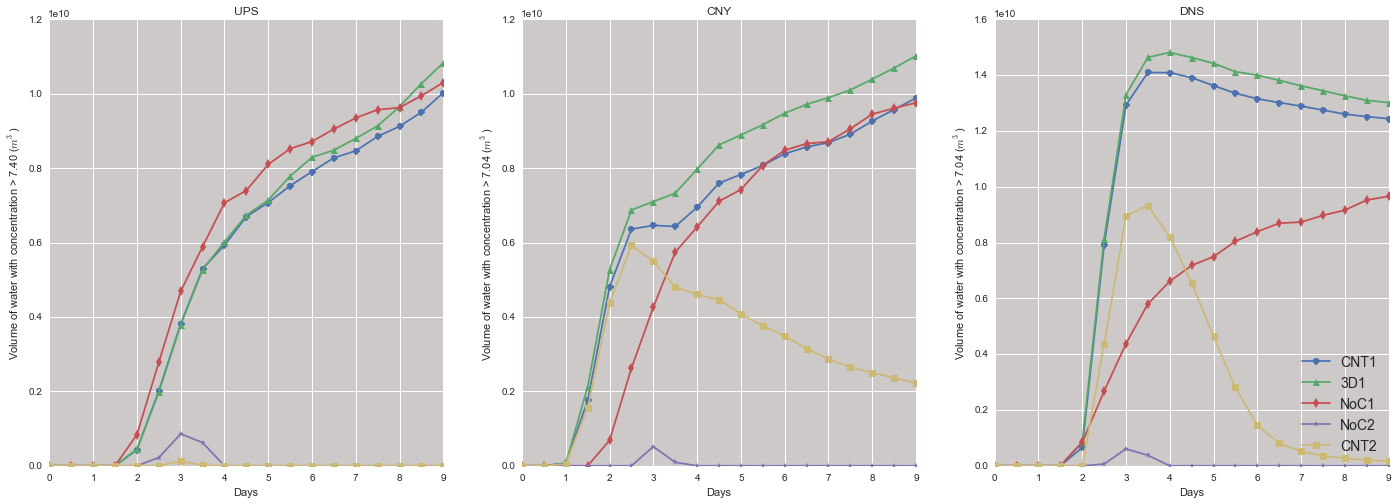

In [366]:
fig45=plt.figure(figsize=(24,8))
sns.set_style('darkgrid')

plt.subplot(1,3,1)
ax = plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(np.linspace(0,9,19),TotWaterUPSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterUPSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterUPSTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.40 ($m^3$)')
plt.xlabel('Days')
plt.title('UPS')
##### 
plt.subplot(1,3,2)
ax = plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(np.linspace(0,9,19),TotWaterCNYTr,'o-',label=('NCT1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterCNYTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterCNYTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.04 ($m^3$) ')
plt.xlabel('Days')
plt.title('CNY')

######
plt.subplot(1,3,3)
ax = plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.plot(np.linspace(0,9,19),TotWaterDNSTr,'o-',label=('CNT1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr3D,'^-',label=('3D1'))
plt.plot(np.linspace(0,9,19),TotWaterDNSTrNoC,'d-',label=('NoC1' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2NoC,'*-',label=('NoC2' ))
plt.plot(np.linspace(0,9,19),TotWaterDNSTr2,'s-',label=('CNT2' ))

plt.ylabel('Volume of water with concentration > 7.04 ($m^3$)')
plt.xlabel('Days')
plt.title('DNS')
plt.legend(loc=4, fontsize=14)

##########################################################################
totalVolumeUPS = 0.0
totalVolumeCNY =0.0 
totalVolumeDNS = 0.0

totalVolumeUPSNoC = 0.0
totalVolumeCNYNoC = 0.0
totalVolumeDNSNoC = 0.0

for kk in range(nz):
    
    totalVolumeUPS = totalVolumeUPS + np.sum(np.sum(hFacCNoC[kk,197:,:120]*drF[kk]*rA[197:,:120]))
    totalVolumeCNY = totalVolumeCNY + np.sum(np.sum(hFacCNoC[kk,197:,120:240]*drF[kk]*rA[197:,120:240]))
    totalVolumeDNS = totalVolumeDNS + np.sum(np.sum(hFacCNoC[kk,197:,:120]*drF[kk]*rA[197:,240:]))

    totalVolumeUPSNoC = totalVolumeUPSNoC + np.sum(np.sum(hFacCNoC[kk,197:,:120]*drFNoC[kk]*rANoC[197:,:120]))
    totalVolumeCNYNoC = totalVolumeCNYNoC + np.sum(np.sum(hFacCNoC[kk,197:,120:240]*drFNoC[kk]*rANoC[197:,120:240]))
    totalVolumeDNSNoC = totalVolumeDNSNoC + np.sum(np.sum(hFacCNoC[kk,197:,:120]*drFNoC[kk]*rANoC[197:,240:]))

print('Total volume ($m^3$) on UPS is :', totalVolumeUPS)  
print('Total volume ($m^3$) on CNY is :', totalVolumeCNY)  
print('Total volume ($m^3$) on DNS is :', totalVolumeDNS)  
print('Total volume ($m^3$) on UPSNoC is :', totalVolumeUPSNoC)  
print('Total volume ($m^3$) on CNYNoC is :', totalVolumeCNYNoC)  
print('Total volume ($m^3$) on DNSNoC is :', totalVolumeDNSNoC)  

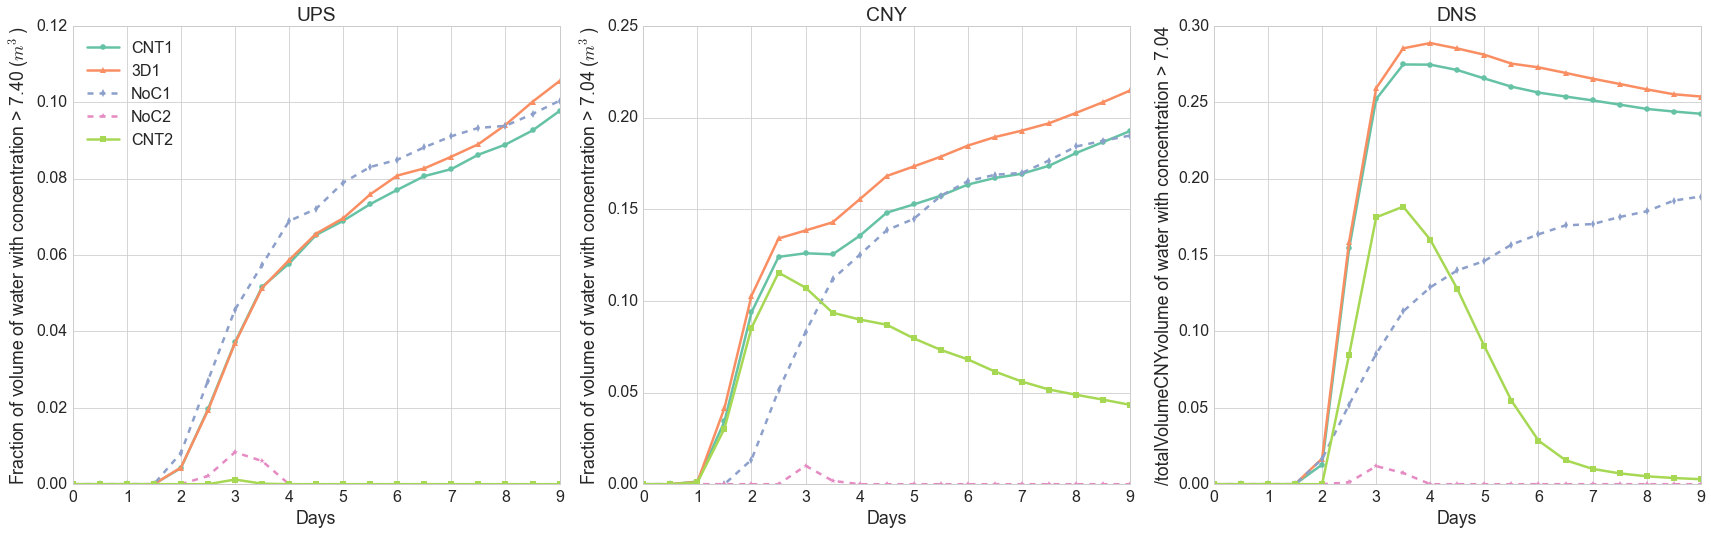

In [388]:
fig45=plt.figure(figsize=(24,8))
 
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})

with sns.color_palette("Set2", 9):

    plt.subplot(1,3,1)
    ax = plt.gca()
    

    plt.plot(np.linspace(0,9,19),TotWaterUPSTr/totalVolumeUPS,'o-',label=('CNT1' ))
    plt.plot(np.linspace(0,9,19),TotWaterUPSTr3D/totalVolumeUPS,'^-',label=('3D1'))
    plt.plot(np.linspace(0,9,19),TotWaterUPSTrNoC/totalVolumeUPS,'d--',label=('NoC1' ))
    plt.plot(np.linspace(0,9,19),TotWaterUPSTr2NoC/totalVolumeUPS,'*--',label=('NoC2' ))
    plt.plot(np.linspace(0,9,19),TotWaterUPSTr2/totalVolumeUPS,'s-',label=('CNT2' ))

    plt.ylabel('Fraction of volume of water with concentration > 7.40 ($m^3$)')
    plt.xlabel('Days')
    plt.title('UPS')
    leg = plt.legend(loc=0)
    ##### 
    plt.subplot(1,3,2)
    ax = plt.gca()
    

    plt.plot(np.linspace(0,9,19),TotWaterCNYTr/totalVolumeCNY,'o-',label=('NCT1' ))
    plt.plot(np.linspace(0,9,19),TotWaterCNYTr3D/totalVolumeCNY,'^-',label=('3D1'))
    plt.plot(np.linspace(0,9,19),TotWaterCNYTrNoC/totalVolumeCNY,'d--',label=('NoC1' ))
    plt.plot(np.linspace(0,9,19),TotWaterCNYTr2NoC/totalVolumeCNY,'*--',label=('NoC2' ))
    plt.plot(np.linspace(0,9,19),TotWaterCNYTr2/totalVolumeCNY,'s-',label=('CNT2' ))

    plt.ylabel('Fraction of volume of water with concentration > 7.04 ($m^3$) ')
    plt.xlabel('Days')
    plt.title('CNY')

    ######
    plt.subplot(1,3,3)
    ax = plt.gca()
    

    plt.plot(np.linspace(0,9,19),TotWaterDNSTr/totalVolumeCNY,'o-',label=('CNT1, $DiffKz = 10^{-5}$' ))
    plt.plot(np.linspace(0,9,19),TotWaterDNSTr3D/totalVolumeCNY,'^-',label=('3D1, $DiffKz_{cny} = 10^{-3}$ \n ,$DiffKz_{out} = 10^{-5}$ '))
    plt.plot(np.linspace(0,9,19),TotWaterDNSTrNoC/totalVolumeCNY,'d--',label=('NoC1, $DiffKz = 10^{-3}$' ))
    plt.plot(np.linspace(0,9,19),TotWaterDNSTr2NoC/totalVolumeCNY,'*--',label=('NoC2, $DiffKz = 10^{-3}$' ))
    plt.plot(np.linspace(0,9,19),TotWaterDNSTr2/totalVolumeCNY,'s-',label=('CNT2, $DiffKz = 10^{-3}$' ))

    plt.ylabel('/totalVolumeCNYvolume of water with concentration > 7.04 ')
    plt.xlabel('Days')
    plt.title('DNS')
    
    plt.tight_layout()
    fig45.subplots_adjust(top=0.9)
    #fig45.savefig('/ocean/kramosmu/Figures/WaterVolumeOverShelf/H2OVolOver_UPS_CNY_DNS_noCnyandCny.eps', format='eps', dpi=1000,bbox_extra_artists=(leg,), bbox_inches='tight')


